### We will follow the 6 CRISP-DM phases for the project. CRoss Industry Standard Process for Data Mining (CRISP-DM) is a process model that serves as the base for a data science process which has six sequential phases, which will step through.

# 1. Business understanding¶

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks  rewards mobile app. Once every few days, Starbucks  sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Our task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. We'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

We are given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

We need to in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

We'll  want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.


### Objective is to find answers to below questions:

- Q1: Build a machine learning model that predicts how much someone will spend based on demographics and offer type.
- Q2: Determine which demographic groups respond best to which offer type.
- Q3: Build a model that predicts whether or not someone will respond to an offer. 

# -----------------------------------------------------------------------------------------------------------

# 2. Data understanding

We are given the data in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record


#### Let's dive in. We will define utility functions as needed along the way.


In [1]:
# libraries used
import pandas as pd
from pandas.plotting import scatter_matrix

import numpy as np
import math
import json
from datetime import datetime
import scipy.stats as stats

from sklearn.metrics import confusion_matrix, silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression, LogisticRegression, LassoCV
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, VotingClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeClassifier

from sklearn.cluster import KMeans
import pickle
import joblib

import matplotlib.pyplot as plt
import seaborn as sns

# global PRINT variable to suppress print
PRINT = False
# gobal purchase_high_limit for outliers
purchase_high_limit = 1200.00

In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# 3. Data preparation
From the initial analysis below we see need to clean up the data for missing values or dropping unneeded attributes. We will organize the data for modeling by selecting few variables, impute missing data in them, and format them. We will create dummy variables for relevant categorical variables.

## Let's analyze the profile dataset:

In [3]:
def printf(*args, **kwargs):
    """
    Utility function, extends the built-in print function, but only prints if the global 
    variable PRINT is True.
    
    Parameters:
    *args: Any number of positional arguments to be passed to print.
    **kwargs: Any keyword arguments to be passed to print.
    """
    if PRINT:
        print(*args, **kwargs)

In [4]:
def info_on_df(df):
    """
    Utility function to prints the shape and column names of a given pandas DataFrame.

    Args:
        df (pandas.DataFrame): The DataFrame to obtain information about.

    Returns:
        None
    """
    print('------------------------------------')
    print("Shape of DataFrame:", df.shape)
    print("Columns of DataFrame:", df.columns)

In [5]:
def create_missing_values_table(df):
    '''
    This function provides stats on missing values on a given dataframe
    input - dataframe
    returns - dataframe that has missing value stats for each column in the input dataframe, including data types,
    number of missing values, and percentage of missing values
    '''
    # Total missing values
    mis_val = df.isnull().sum()

    # Percentage of missing values
    mis_val_percent = 100 * df.isnull().sum() / len(df)

    # data types of those columns with missing values
    mis_dtypes = df[df.isnull()].dtypes

    # Make a table with the results
    mis_val_table = pd.concat([mis_dtypes, mis_val, mis_val_percent], axis=1)

    # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(columns={
        0: 'DataTypes',
        1: 'Missing Values',
        2: '% of Total Values'
    })

    # Sort the table by percentage of missing descending
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:, 1] != 0].sort_values(
            '% of Total Values', ascending=False).round(1)

    # Print some summary information
    print("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"
          "There are " + str(mis_val_table_ren_columns.shape[0]) +
          " columns that have missing values.")

    # Return the dataframe with missing information
    return mis_val_table_ren_columns

In [6]:
#Let's see the profile data & strcuture
printf("profile Sample Data:\n", profile.head())

printf("\n profile info: \n", profile.info())

printf("\n profile summary stats:\n", profile.describe(include='all'))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [7]:
# Call create_missing_values_table function with profile df
create_missing_values_table(profile)

Your selected dataframe has 5 columns.
There are 2 columns that have missing values.


,DataTypes,Missing Values,% of Total Values
gender,object,2175,12.8
income,float64,2175,12.8


#### There are about 13% missing gender and income values.

In [8]:
# Let's see the breakdown of missing values in gender
profile["gender"].value_counts(dropna=False) / profile.shape[0]

M       0.499059
F       0.360529
None    0.127941
O       0.012471
Name: gender, dtype: float64

In [9]:
# fill missing values in gender with U as in unknown.
profile.fillna(value={"gender": "U"}, inplace=True)

# Let's see the breakdown of missing values in gender
profile["gender"].value_counts(dropna=False) / profile.shape[0]

M    0.499059
F    0.360529
U    0.127941
O    0.012471
Name: gender, dtype: float64

In [10]:
# let's see the average income by gender
profile[['gender', 'income']].groupby(by="gender", dropna=False).mean()

,income
gender,
F,71306.412139
M,61194.601603
O,63287.735849
U,NaN


In [11]:
# These missing values can be imputed to average in income for each gender
profile.loc[profile['gender'] == 'M',
            'income'] = profile.loc[profile['gender'] == 'M',
                                    'income'].interpolate(method='linear')
profile.loc[profile['gender'] == 'F',
            'income'] = profile.loc[profile['gender'] == 'F',
                                    'income'].interpolate(method='linear')

profile.loc[profile['gender'] == 'O',
            'income'] = profile.loc[profile['gender'] == 'O',
                                    'income'].interpolate(method='linear')

profile['income'].interpolate(method='linear', inplace=True)

In [12]:
profile['income'].describe()

count     16999.000000
mean      65439.761162
std       20946.694159
min       30000.000000
25%       50000.000000
50%       64000.000000
75%       79000.000000
max      120000.000000
Name: income, dtype: float64

[Text(0, 0, '1799'),
 Text(0, 0, '1923'),
 Text(0, 0, '2629'),
 Text(0, 0, '2674'),
 Text(0, 0, '2763'),
 Text(0, 0, '1745'),
 Text(0, 0, '1409'),
 Text(0, 0, '1060'),
 Text(0, 0, '532'),
 Text(0, 0, '465')]

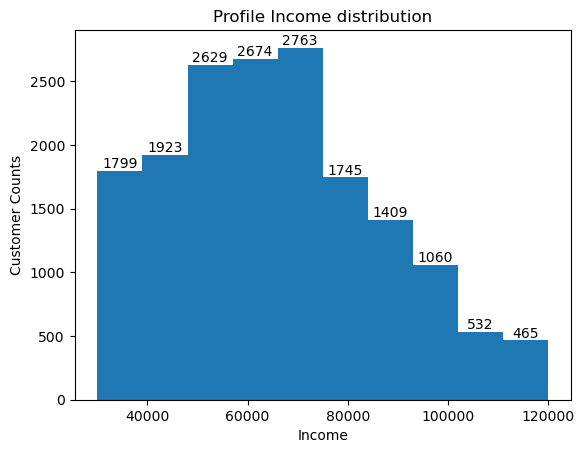

In [13]:
# let's see the income distribution
counts, edges, bars = plt.hist(profile["income"])
plt.xlabel("Income")
plt.ylabel("Customer Counts")
plt.title('Profile Income distribution')
plt.bar_label(bars)

<AxesSubplot: title={'center': 'Profile boxplot for income'}>

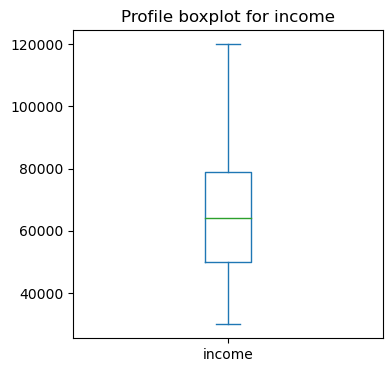

In [14]:
# lets check if there are any outliers
profile["income"].plot.box(title="Profile boxplot for income", figsize=(4, 4))

### Boxplot above does not show any outliers in the income variable.

In [15]:
def remove_purchase_outliers(df, column):
    """
    Utility function to remove outliers from a DataFrame based on the specified column.
    Parameters:
    df : The DataFrame containing the data to remove outliers from.
    column : str, name of the column to remove outliers from.
    Returns: new DataFrame with the outliers removed.
    """
    print("\n---In function remove_purchase_outliers ---\n")
    info_on_df(df)
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    df_clean = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    # find how many rows are left in the dataframe
    info_on_df(df_clean)
    print("\n---Leaving function remove_purchase_outliers ---\n")
    return df_clean

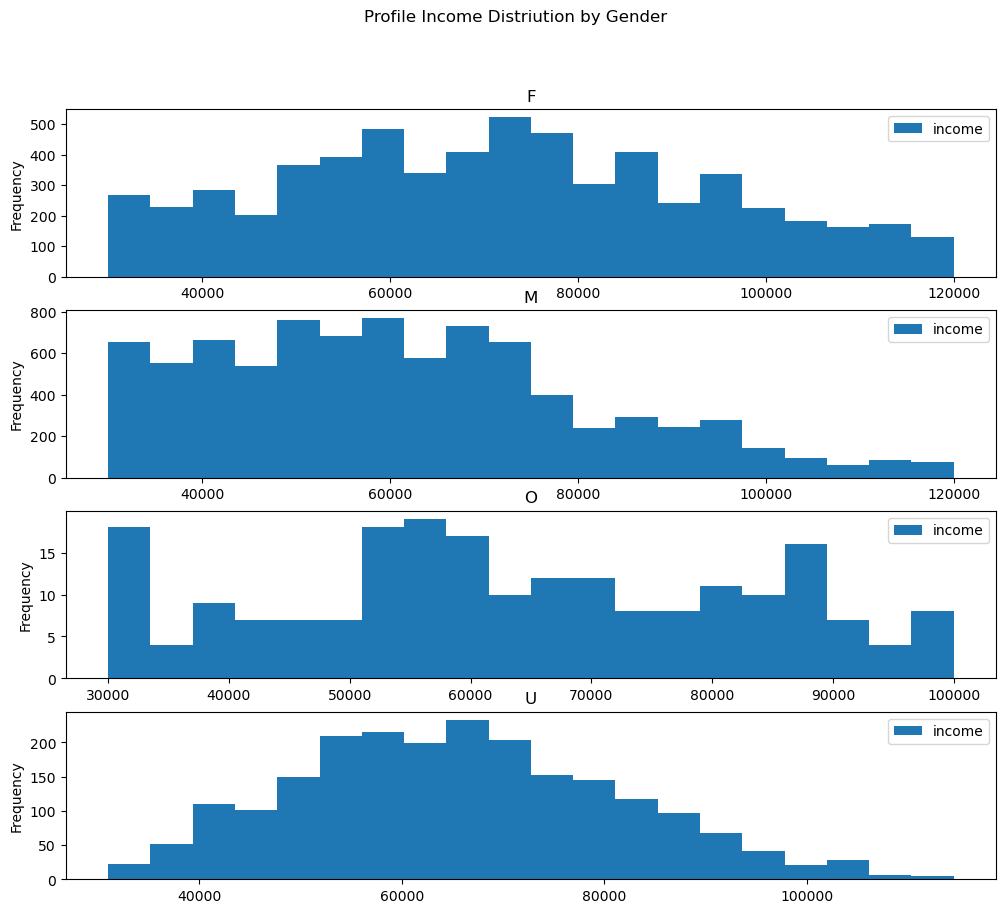

In [16]:
# let's see the income distribution by gender
ax = profile.plot.hist(column=["income"],
                       by="gender",
                       figsize=(12, 10),
                       bins=20,
                       title="Profile Income Distriution by Gender")

In [17]:
def create_income_bins(df):
    '''
    This function will create income dummy variables for each bin in the 10k day increments.
    input - dataframe
    returns - dataframe with dummy variables for "income" variable without original variable.
    '''
    bins = pd.cut(df['income'], [
        10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000,
        110000, 120000, np.inf
    ],
                  labels=[
                      '0_20k', '20_30k', '30_40k', '40_50k', '50_60k',
                      '60_70k', '70_80k', '80_90k', '90_100k', '100_110k',
                      '110_120k', '120+'
                  ])
    df = pd.concat([df, pd.get_dummies(bins, prefix='income')], axis=1)
    df = df.drop(['income'], axis=1)  # ,'member_tenure_days'
    return df

In [18]:
# create income dummy variables
profiledf1 = create_income_bins(profile)
info_on_df(profiledf1)

------------------------------------
Shape of DataFrame: (17000, 16)
Columns of DataFrame: Index(['gender', 'age', 'id', 'became_member_on', 'income_0_20k',
       'income_20_30k', 'income_30_40k', 'income_40_50k', 'income_50_60k',
       'income_60_70k', 'income_70_80k', 'income_80_90k', 'income_90_100k',
       'income_100_110k', 'income_110_120k', 'income_120+'],
      dtype='object')


[Text(0, 0, '1308'),
 Text(0, 0, '1438'),
 Text(0, 0, '2054'),
 Text(0, 0, '3383'),
 Text(0, 0, '3257'),
 Text(0, 0, '2031'),
 Text(0, 0, '966'),
 Text(0, 0, '361'),
 Text(0, 0, '27'),
 Text(0, 0, '2175')]

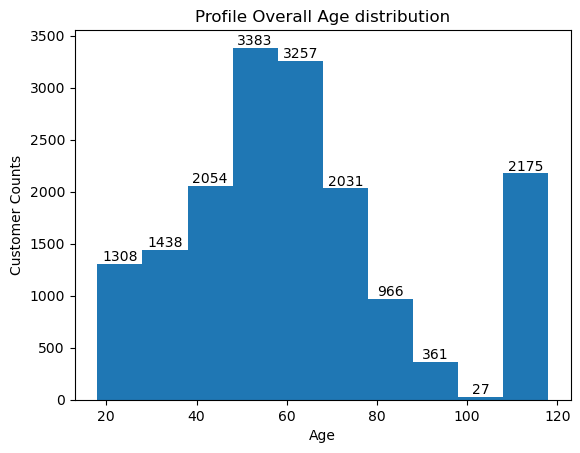

In [19]:
# let's see the age distribution
counts, edges, bars = plt.hist(profiledf1["age"])
plt.xlabel("Age")
plt.ylabel("Customer Counts")
plt.title('Profile Overall Age distribution')
plt.bar_label(bars)

<AxesSubplot: title={'center': 'Profile Age Boxplot'}>

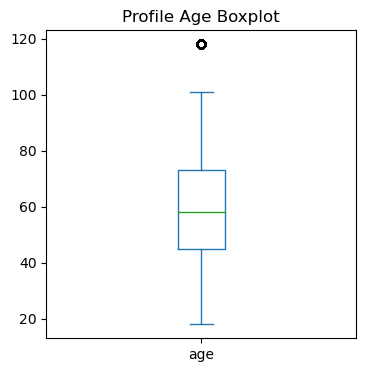

In [20]:
# We do see a lot more observations with age 120! let's see boxplot
profiledf1["age"].plot.box(title="Profile Age Boxplot", figsize=(4, 4))

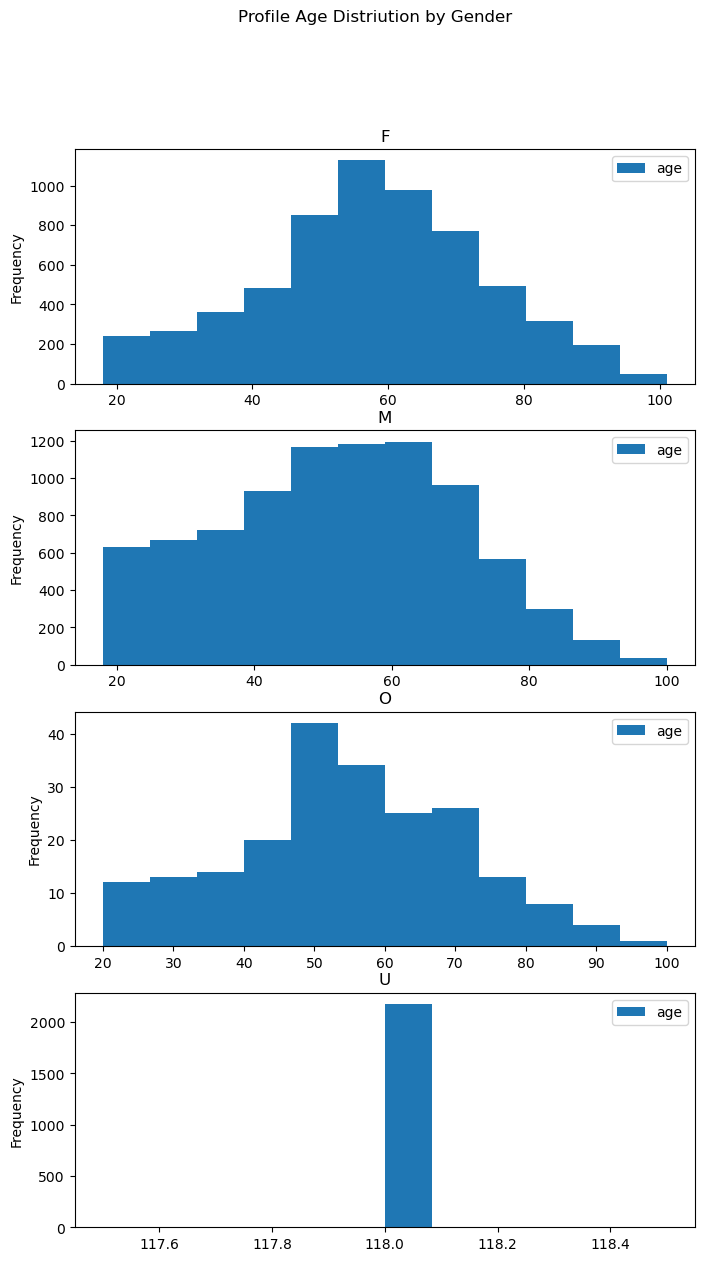

In [21]:
ax = profiledf1.plot.hist(column=["age"],
                          by="gender",
                          bins=12,
                          figsize=(8, 14),
                          title="Profile Age Distriution by Gender")

### We see 2180 observations with unknown gender have age over 100 years. Most likely customers chose not  to disclose gender as well as age. Since this is significant, portion (12.8%) of the data, we will leave it as is.

In [22]:
# Let's see the if there are missing values in became_member_on
profiledf1["became_member_on"].isna().mean()

0.0

In [23]:
# Let's see the counts of members by there membership begin date
profiledf1['became_member_on'].value_counts().sort_values(ascending=False)

20171207    43
20170819    42
20171007    40
20171113    39
20170928    38
            ..
20140228     1
20150407     1
20141128     1
20131117     1
20130922     1
Name: became_member_on, Length: 1716, dtype: int64

<AxesSubplot: title={'center': 'Profile Boxplot for became_member_on'}>

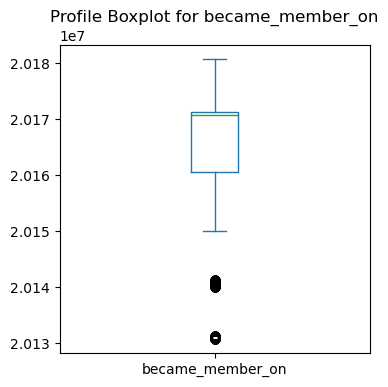

In [24]:
# We see old dates from 2013 above; let's see boxplot:
profiledf1['became_member_on'].plot.box(
    title="Profile Boxplot for became_member_on", figsize=(4, 4))

### Even though we see outliers on the above boxplot for the became_member_on, we will leave them since these customers could have been members from long time ago and they are still using the app.

In [25]:
def create_member_tenure_bins(df):
    '''
    This function will create a new column "became_member_on" and it will calculate the 
    difference between the became_member_on and 2018-08-01 date 2018-07-26 is the max date 
    for the became_member_on. If the became_member_on is not present then it will assign None 
    to that record. Then it will create dummy variables for each bin in the 10 day increments.
    input - dataframe
    returns - dataframe with dummy variables for "member_tenure" variable without 
    original variable.
    '''

    df['became_member_on_date'] = pd.to_datetime(df['became_member_on'],
                                                 format='%Y%m%d',
                                                 errors='coerce')

    print("Latest date someone became a member=",
          df["became_member_on_date"].max())

    # 2018-07-26 is the max date for the became_member_on
    # not using datetime.now() since using today's date will increse the tenure to
    # unrealistic level

    todey = pd.to_datetime('20180801', format='%Y%m%d', errors='coerce')

    # compute member_tenure_days
    df.loc[df['became_member_on_date'].notna(),
           'member_tenure_days'] = (todey -
                                    df['became_member_on_date']).dt.days

    # create bins on member_tenure_days
    bins = pd.cut(df['member_tenure_days'], [
        0, 15, 30, 45, 60, 75, 90, 105, 120, 135, 150, 165, 180, 195, 210, 225,
        240, 255, 270, 285, 300, 315, 330, 345, 360, 365, np.inf
    ],
                  labels=[
                      '0_15', '15_30', '30_45', '45_60', '60_75', '75_90',
                      '90_105', '105_120', '120_135', '135_150', '150_165',
                      '165_180', '180_195', '195_210', '210_225', '225_240',
                      '240_255', '255_270', '270_285', '285_300', '300_315',
                      '315_330', '330_345', '345_360', '360_365', '365+'
                  ])
    df = pd.concat([df, pd.get_dummies(bins, prefix='tenure_days')], axis=1)
    df = df.drop(['became_member_on', 'became_member_on_date'], axis=1)
    return df

In [26]:
# call the function to create the tenure bins on became_member_on
profiledf2 = create_member_tenure_bins(profiledf1)

info_on_df(profiledf2)

Latest date someone became a member= 2018-07-26 00:00:00
------------------------------------
Shape of DataFrame: (17000, 42)
Columns of DataFrame: Index(['gender', 'age', 'id', 'income_0_20k', 'income_20_30k', 'income_30_40k',
       'income_40_50k', 'income_50_60k', 'income_60_70k', 'income_70_80k',
       'income_80_90k', 'income_90_100k', 'income_100_110k', 'income_110_120k',
       'income_120+', 'member_tenure_days', 'tenure_days_0_15',
       'tenure_days_15_30', 'tenure_days_30_45', 'tenure_days_45_60',
       'tenure_days_60_75', 'tenure_days_75_90', 'tenure_days_90_105',
       'tenure_days_105_120', 'tenure_days_120_135', 'tenure_days_135_150',
       'tenure_days_150_165', 'tenure_days_165_180', 'tenure_days_180_195',
       'tenure_days_195_210', 'tenure_days_210_225', 'tenure_days_225_240',
       'tenure_days_240_255', 'tenure_days_255_270', 'tenure_days_270_285',
       'tenure_days_285_300', 'tenure_days_300_315', 'tenure_days_315_330',
       'tenure_days_330_345', 't

C:\Users\Admin\AppData\Local\Temp\ipykernel_16100\3343035150.py:26: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[df['became_member_on_date'].notna(),


[Text(0, 0, '3556'),
 Text(0, 0, '5135'),
 Text(0, 0, '1748'),
 Text(0, 0, '1715'),
 Text(0, 0, '1795'),
 Text(0, 0, '1658'),
 Text(0, 0, '362'),
 Text(0, 0, '326'),
 Text(0, 0, '362'),
 Text(0, 0, '343')]

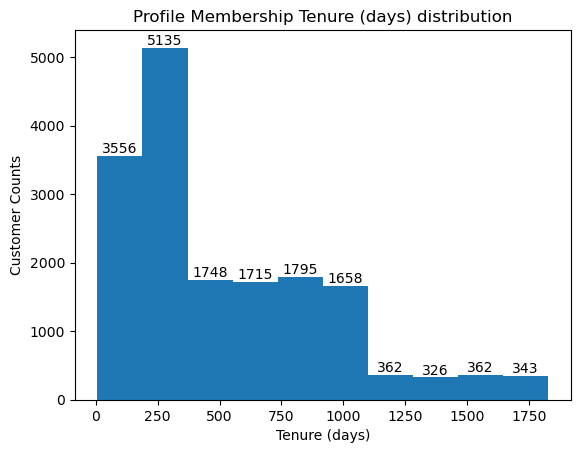

In [27]:
# plot the Membership Tenure distribution
counts, edges, bars = plt.hist(profiledf2["member_tenure_days"])
plt.xlabel("Tenure (days)")
plt.ylabel("Customer Counts")
plt.title('Profile Membership Tenure (days) distribution')
plt.bar_label(bars)

<AxesSubplot: title={'center': 'Profile member tenure (days) boxplot'}>

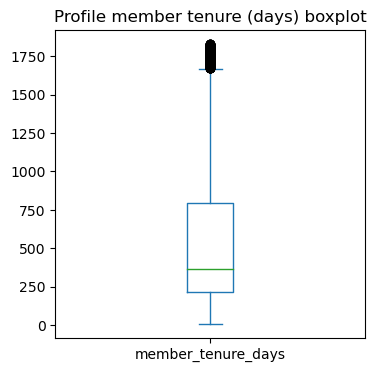

In [28]:
# boxplot for outliers in member_tenure_days
profiledf2["member_tenure_days"].plot.box(
    title="Profile member tenure (days) boxplot", figsize=(4, 4))

### We observe outliers on the top with longer tenures; we already decided to keep the long tenured customers.

In [29]:
profiledf2.describe(include='all')

,gender,age,id,income_0_20k,income_20_30k,income_30_40k,income_40_50k,income_50_60k,income_60_70k,income_70_80k,...,tenure_days_240_255,tenure_days_255_270,tenure_days_270_285,tenure_days_285_300,tenure_days_300_315,tenure_days_315_330,tenure_days_330_345,tenure_days_345_360,tenure_days_360_365,tenure_days_365+
count,17000,17000.000000,17000,17000.0,17000.000000,17000.000000,17000.0000,17000.000000,17000.000000,17000.000000,...,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.00000,17000.000000,17000.000000
unique,4,NaN,17000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,M,NaN,68be06ca386d4c31939f3a4f0e3dd783,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,8484,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,62.531412,NaN,0.0,0.005176,0.125941,0.1280,0.185118,0.168235,0.153118,...,0.024588,0.024235,0.024647,0.025706,0.025706,0.023882,0.023529,0.02600,0.008941,0.497882
std,NaN,26.738580,NaN,0.0,0.071763,0.331793,0.3341,0.388404,0.374086,0.360111,...,0.154871,0.153783,0.155052,0.158261,0.158261,0.152687,0.151582,0.15914,0.094137,0.500010
min,NaN,18.000000,NaN,0.0,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,NaN,45.000000,NaN,0.0,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
50%,NaN,58.000000,NaN,0.0,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
75%,NaN,73.000000,NaN,0.0,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,1.000000


In [30]:
# Convert gender categorical var to dummies
profiledf3 = pd.concat(
    [profiledf2,
     pd.get_dummies(profiledf1["gender"], prefix='gender')],
    axis=1)

# drop gender, member_tenure_days from the dataset
profiledf3.drop(['gender', "member_tenure_days"], axis=1, inplace=True)

info_on_df(profiledf3)

------------------------------------
Shape of DataFrame: (17000, 44)
Columns of DataFrame: Index(['age', 'id', 'income_0_20k', 'income_20_30k', 'income_30_40k',
       'income_40_50k', 'income_50_60k', 'income_60_70k', 'income_70_80k',
       'income_80_90k', 'income_90_100k', 'income_100_110k', 'income_110_120k',
       'income_120+', 'tenure_days_0_15', 'tenure_days_15_30',
       'tenure_days_30_45', 'tenure_days_45_60', 'tenure_days_60_75',
       'tenure_days_75_90', 'tenure_days_90_105', 'tenure_days_105_120',
       'tenure_days_120_135', 'tenure_days_135_150', 'tenure_days_150_165',
       'tenure_days_165_180', 'tenure_days_180_195', 'tenure_days_195_210',
       'tenure_days_210_225', 'tenure_days_225_240', 'tenure_days_240_255',
       'tenure_days_255_270', 'tenure_days_270_285', 'tenure_days_285_300',
       'tenure_days_300_315', 'tenure_days_315_330', 'tenure_days_330_345',
       'tenure_days_345_360', 'tenure_days_360_365', 'tenure_days_365+',
       'gender_F', 'gende

In [31]:
def create_age_bins(df):
    '''
    This function will create age dummy variables for each bin in the 10 year increments.
    input - dataframe
    returns - dataframe with dummy variables for "age" variable without original variable.
    '''
    bins = pd.cut(df['age'], [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, np.inf],
                  labels=[
                      '0_20y', '20_30y', '30_40y', '40_50y', '50_60y',
                      '60_70y', '70_80y', '80_90y', '90_100y', '100+'
                  ])
    df = pd.concat([df, pd.get_dummies(bins, prefix='age')], axis=1)
    df = df.drop(['age'], axis=1)
    return df

In [32]:
# call the function to create age bins
profiledf4 = create_age_bins(profiledf3)
info_on_df(profiledf4)

------------------------------------
Shape of DataFrame: (17000, 53)
Columns of DataFrame: Index(['id', 'income_0_20k', 'income_20_30k', 'income_30_40k', 'income_40_50k',
       'income_50_60k', 'income_60_70k', 'income_70_80k', 'income_80_90k',
       'income_90_100k', 'income_100_110k', 'income_110_120k', 'income_120+',
       'tenure_days_0_15', 'tenure_days_15_30', 'tenure_days_30_45',
       'tenure_days_45_60', 'tenure_days_60_75', 'tenure_days_75_90',
       'tenure_days_90_105', 'tenure_days_105_120', 'tenure_days_120_135',
       'tenure_days_135_150', 'tenure_days_150_165', 'tenure_days_165_180',
       'tenure_days_180_195', 'tenure_days_195_210', 'tenure_days_210_225',
       'tenure_days_225_240', 'tenure_days_240_255', 'tenure_days_255_270',
       'tenure_days_270_285', 'tenure_days_285_300', 'tenure_days_300_315',
       'tenure_days_315_330', 'tenure_days_330_345', 'tenure_days_345_360',
       'tenure_days_360_365', 'tenure_days_365+', 'gender_F', 'gender_M',
       '

In [33]:
# double check if there are any missing values.
create_missing_values_table(profiledf4)

Your selected dataframe has 53 columns.
There are 0 columns that have missing values.


,DataTypes,Missing Values,% of Total Values


In [34]:
info_on_df(profiledf4)

------------------------------------
Shape of DataFrame: (17000, 53)
Columns of DataFrame: Index(['id', 'income_0_20k', 'income_20_30k', 'income_30_40k', 'income_40_50k',
       'income_50_60k', 'income_60_70k', 'income_70_80k', 'income_80_90k',
       'income_90_100k', 'income_100_110k', 'income_110_120k', 'income_120+',
       'tenure_days_0_15', 'tenure_days_15_30', 'tenure_days_30_45',
       'tenure_days_45_60', 'tenure_days_60_75', 'tenure_days_75_90',
       'tenure_days_90_105', 'tenure_days_105_120', 'tenure_days_120_135',
       'tenure_days_135_150', 'tenure_days_150_165', 'tenure_days_165_180',
       'tenure_days_180_195', 'tenure_days_195_210', 'tenure_days_210_225',
       'tenure_days_225_240', 'tenure_days_240_255', 'tenure_days_255_270',
       'tenure_days_270_285', 'tenure_days_285_300', 'tenure_days_300_315',
       'tenure_days_315_330', 'tenure_days_330_345', 'tenure_days_345_360',
       'tenure_days_360_365', 'tenure_days_365+', 'gender_F', 'gender_M',
       '

# Create demographic clusters on profiledf4:

In [35]:
def find_optimal_numclusters(X_train_arr, min_clusters=4, max_clusters=16):
    """
    Finds the optimal number of clusters using KMeans clustering for a given dataset.
    
    Parameters:
    -----------
    X_train_arr : array-like
        Array containing the data points for clustering
    min_clusters : int, optional, default: 4
        Minimum number of clusters to try
    max_clusters : int, optional, default: 16
        Maximum number of clusters to try

    Returns:
    --------
    df_scores : pd.DataFrame
        DataFrame containing the clustering scores for different numbers of clusters
    """

    # scale the data
    scaler = StandardScaler(with_mean=True)
    scaler.fit(X_train_arr)

    # step to find optimal number of clusters
    seed_random = 42

    fitted_kmeans = {}
    labels_kmeans = {}
    df_scores = []
    k_values_to_try = np.arange(min_clusters, max_clusters)

    for n_clusters in k_values_to_try:
        #Perform clustering.
        kmeans = KMeans(n_clusters=n_clusters,
                        random_state=seed_random,
                        verbose=0)

        labels_clusters = kmeans.fit_predict(X_train_arr)

        #Insert fitted model and calculated cluster labels in dictionaries,
        #for further reference.
        fitted_kmeans[n_clusters] = kmeans
        labels_kmeans[n_clusters] = labels_clusters

        #Calculate various scores, and save them for further reference.
        silhouette = silhouette_score(X_train_arr, labels_clusters)
        ch = calinski_harabasz_score(X_train_arr, labels_clusters)
        db = davies_bouldin_score(X_train_arr, labels_clusters)
        tmp_scores = {
            "n_clusters": n_clusters,
            "silhouette_score": silhouette,
            "calinski_harabasz_score": ch,
            "davies_bouldin_score": db,
        }
        df_scores.append(tmp_scores)

    #Create a DataFrame of clustering scores, using `n_clusters` as index, for easier plotting.
    df_scores = pd.DataFrame(df_scores)
    df_scores.set_index("n_clusters", inplace=True)

    # Elbow plot
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    df_scores["silhouette_score"].plot(ax=axs[0],
                                       title="silhouette_score, higher better")
    df_scores["calinski_harabasz_score"].plot(
        ax=axs[1], title="calinski_harabasz_score, higher better")
    df_scores["davies_bouldin_score"].plot(
        ax=axs[2], title="davies_bouldin_score, lower better")

    plt.show()

    return df_scores

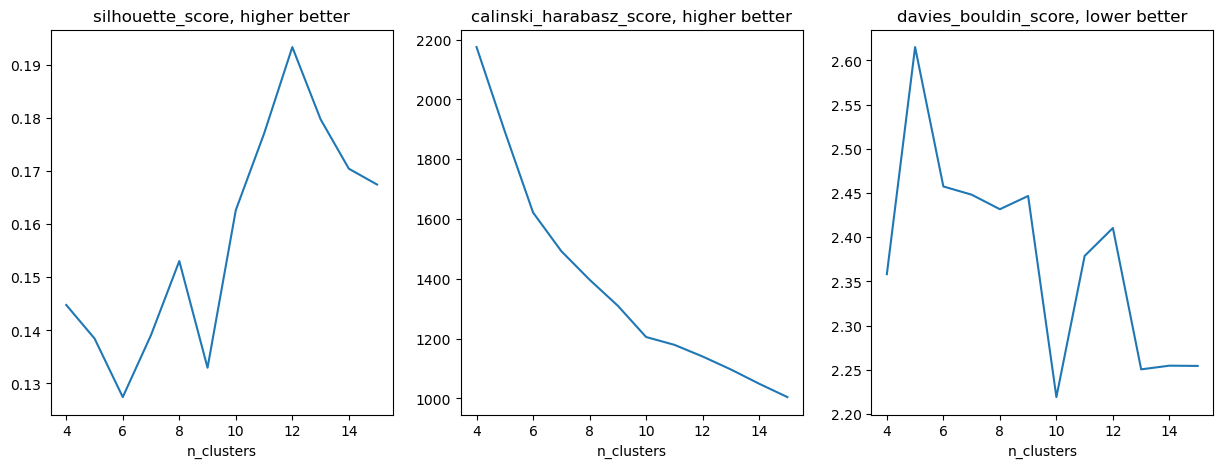

In [36]:
# make a copy of profiledf4, drop id column
profiledf5 = profiledf4.copy()

# drop id column
profiledf5.drop(["id"], axis=1, inplace=True)

# call the function to find the optimal number of clusters
PRINT = True
df_cluster_scores = find_optimal_numclusters(profiledf5,
                                             min_clusters=4,
                                             max_clusters=16)

In [37]:
# See Calinski Harabasz scores
df_cluster_scores

,silhouette_score,calinski_harabasz_score,davies_bouldin_score
n_clusters,,,
4,0.144770,2174.846531,2.358141
5,0.138453,1892.512042,2.615103
6,0.127401,1621.399579,2.457364
7,0.139104,1492.139802,2.448088
8,0.153051,1396.636517,2.431623
9,0.132933,1309.515751,2.446597
10,0.162654,1204.999741,2.219040
11,0.177073,1178.881671,2.378778
12,0.193399,1139.788112,2.410389


Based on the Calinski-Harabasz scores, the optimal number of clusters appears to be at or around 10, which has the highest score of 1204.999741. This is where the score starts to level off, indicating diminishing returns from increasing the number of clusters. Why: The Calinski-Harabasz score tends to favor solutions that have well-separated and compact clusters, whereas the silhouette score measures the degree of similarity between points within a cluster and dissimilarity between points in different clusters. The Davis Bouldin score is the lowest for 10 clusters.
#### Let's go with 12 clusters since thru iteration, observed that with 10 clusters, cluster1 has highest number of customers making them skewed, especially the models predicting the clusters .

In [38]:
def create_clusters_on_df(X_train, numClusters=8):
    """
    Applies KMeans clustering to the input data and returns the predicted cluster labels 
    for each data point.

    Parameters:
        X_train (pandas.DataFrame): Input data to apply clustering to.
        numClusters (int): Number of clusters to generate (default is 8).

    Returns:
        y_train_pred (numpy.ndarray): Predicted cluster labels for each data point.
        X_train_pred_clusterdf (pandas.DataFrame): cluster centers for each cluster
        modelkm : kmeans model itself
    """
    # convert df to an array for KMeans
    X_train_arr = np.array(X_train)
    printf("X_train_arr.shape:", X_train_arr.shape)

    # fit the kmeans model to X_train_arr data
    modelkm = KMeans(n_clusters=numClusters, verbose=0,
                     random_state=42).fit(X_train_arr)

    # printf max modelkm labels
    printf("no. clusters X_train:", max(modelkm.labels_) + 1)

    # let's predict k-means clustering on X_train_arr
    y_train_pred = modelkm.predict(X_train_arr)
    printf("y_train_pred shape:", y_train_pred.shape)

    # what are the cluster centers
    printf("Cluster centers:\n", modelkm.cluster_centers_.shape)

    # Store cluster centers as DF; add column names; transpose and round values to 2
    # after decimal
    X_train_pred_clusterdf = pd.DataFrame(
        modelkm.cluster_centers_, columns=X_train.columns).transpose().apply(
            lambda x: np.abs(round(x, 2)))

    # Name the clusters
    cols = ['cluster{}'.format(i + 1) for i in range(numClusters)]
    X_train_pred_clusterdf.columns = cols

    # printf cluster details
    X_train_pred_clusterdf.sort_values(by=cols, ascending=False, inplace=True)
    printf(X_train_pred_clusterdf)

    return y_train_pred, X_train_pred_clusterdf, modelkm

In [39]:
def save_model(model, model_filepath):
    '''
    Saves model to a file
    input:
        model: model 
        model_filepath : string that has file path to store the model
    Returns:
        none
    '''
    with open(model_filepath, 'wb') as pklfile:
        pickle.dump(model, pklfile)

#### Call the function to predict the clusters on profile df5

In [40]:
# call the function to predict the clusters
PRINT = False
NumClusters = 12
profiledf5_cluster_pred, X_train_pred_clusterdf, modelkm = create_clusters_on_df(
    profiledf5, NumClusters)

# Save the model to a file
filepath = 'modelkm.pkl'
save_model(modelkm, filepath)

# print min and max cluster numbers from profiledf5_cluster_pred
print("Min cluster#=", profiledf5_cluster_pred.min())
print("Max cluster#=", profiledf5_cluster_pred.max())

Min cluster#= 0
Max cluster#= 11


# Let's test the saved model and predict k-means clustering on test data

In [41]:
# import joblib
# load model
model = joblib.load('modelkm.pkl')
# profiledf5.iloc[5421].transpose()

In [42]:
xDataPointforKmeans = np.array(profiledf5)[5421, ].reshape(
    1, -1)  ## Needs work here; see note below
printf(xDataPointforKmeans.shape)

yPredforKmeans = modelkm.predict(xDataPointforKmeans)
printf("yPredforKmeans shape:", yPredforKmeans.shape)
print("predicted cluster for the given xDataPointforKmeans=", yPredforKmeans)

predicted cluster for the given xDataPointforKmeans= [2]


# Needs work here to build a function with steps to convert customer's age, income, gender, and member_since to dummary variables so that resulting record can be used to call the kmeans model to predict the cluster for that customer.

[Text(0, 0, '1974'),
 Text(0, 0, '1334'),
 Text(0, 0, '1066'),
 Text(0, 0, '2175'),
 Text(0, 0, '1826'),
 Text(0, 0, '1616'),
 Text(0, 0, '1576'),
 Text(0, 0, '1642'),
 Text(0, 0, '905'),
 Text(0, 0, '526'),
 Text(0, 0, '874'),
 Text(0, 0, '1486')]

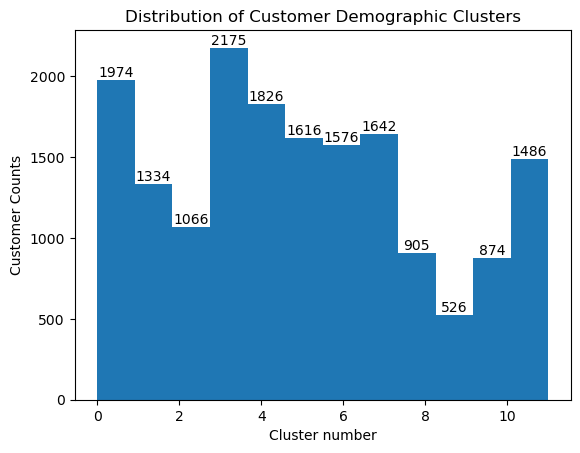

In [43]:
# assign the cluster from above to each customer in the profile
profiledf4['cluster'] = profiledf5_cluster_pred

# plot no. of customers by cluster
counts, edges, bars = plt.hist(profiledf4['cluster'], bins=NumClusters)
plt.title("Distribution of Customer Demographic Clusters")
plt.xlabel("Cluster number")
plt.ylabel("Customer Counts")
plt.bar_label(bars)

In [44]:
# Let's see cluster centers in the X_train_pred_clusterdf
X_train_pred_clusterdf.head(2)

,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,cluster7,cluster8,cluster9,cluster10,cluster11,cluster12
age_50_60y,1.00,0.0,0.00,0.0,0.0,1.0,0.00,0.00,0.0,0.0,0.00,0.00
gender_M,0.99,0.0,0.98,0.0,0.0,0.0,0.98,0.99,0.0,0.0,0.97,0.98


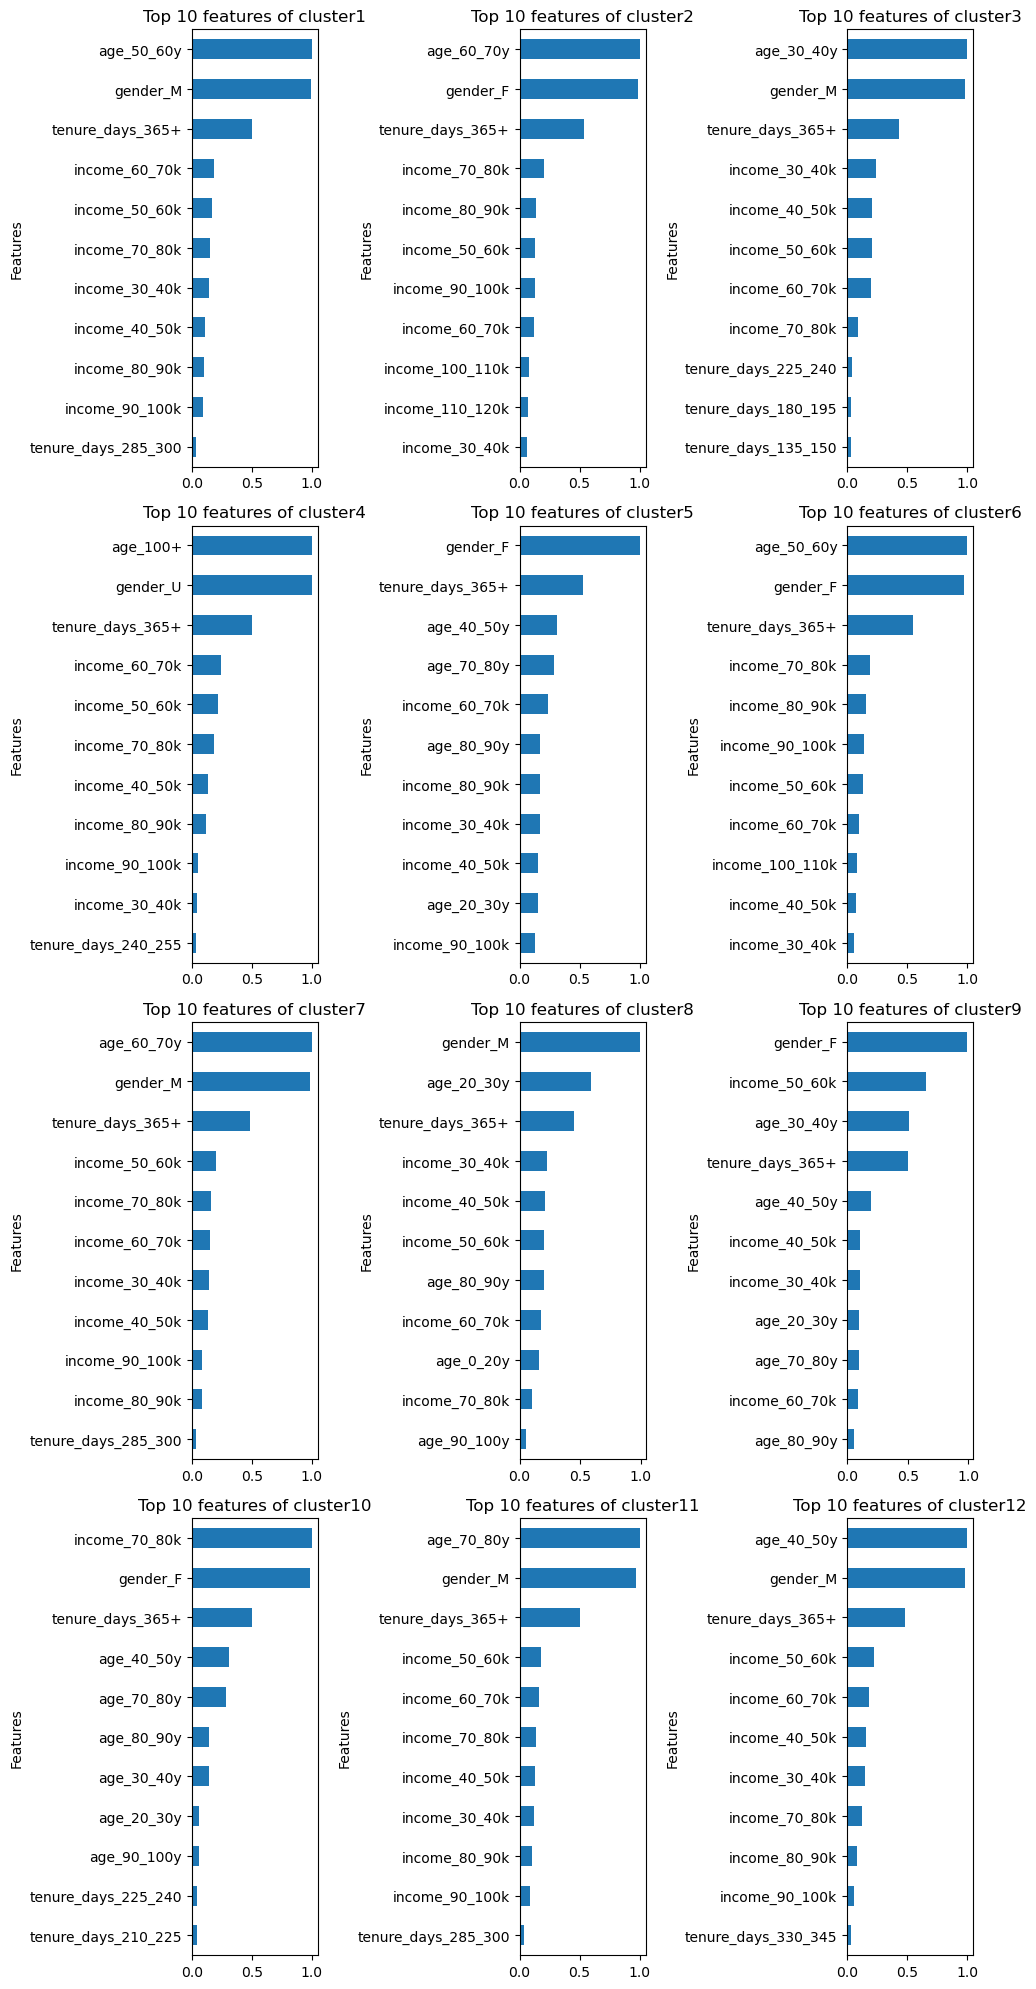

In [45]:
# print individiul clusters with top 10 features influencing it
# below range starts with 1 since our first cluster is named cluster1 as we see above

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(10, 20))

for i, ax in enumerate(axes.flatten()):
    if i + 1 <= NumClusters:
        cluster_name = 'cluster{}'.format(i + 1)
        top_10 = X_train_pred_clusterdf[cluster_name].sort_values(
            ascending=False)[:11]
        top_10.sort_values(ascending=True, inplace=True)
        top_10_df = pd.DataFrame({'index': top_10.index, 'col': top_10.values})
        top_10_df = top_10_df.reset_index(drop=True)
        real_cluster_name = 'cluster{}'.format(i + 1)
        top_10_df.plot(kind='barh',
                       x='index',
                       y='col',
                       legend=False,
                       ax=ax,
                       title='Top 10 features of {}'.format(real_cluster_name))
        ax.set_ylabel('Features')
    else:
        ax.axis('off')

fig.tight_layout()

In [46]:
# check once more if any missing values
create_missing_values_table(profiledf4)

# Make a clean version for profile to use in subsequent steps and also save to csv
profileDF_clean = profiledf4.copy()
profileDF_clean.to_csv("profileDF_clean.csv")
info_on_df(profileDF_clean)

Your selected dataframe has 54 columns.
There are 0 columns that have missing values.
------------------------------------
Shape of DataFrame: (17000, 54)
Columns of DataFrame: Index(['id', 'income_0_20k', 'income_20_30k', 'income_30_40k', 'income_40_50k',
       'income_50_60k', 'income_60_70k', 'income_70_80k', 'income_80_90k',
       'income_90_100k', 'income_100_110k', 'income_110_120k', 'income_120+',
       'tenure_days_0_15', 'tenure_days_15_30', 'tenure_days_30_45',
       'tenure_days_45_60', 'tenure_days_60_75', 'tenure_days_75_90',
       'tenure_days_90_105', 'tenure_days_105_120', 'tenure_days_120_135',
       'tenure_days_135_150', 'tenure_days_150_165', 'tenure_days_165_180',
       'tenure_days_180_195', 'tenure_days_195_210', 'tenure_days_210_225',
       'tenure_days_225_240', 'tenure_days_240_255', 'tenure_days_255_270',
       'tenure_days_270_285', 'tenure_days_285_300', 'tenure_days_300_315',
       'tenure_days_315_330', 'tenure_days_330_345', 'tenure_days_345_36

# ===============================================
# Now let's look at the portfolio dataset.

In [47]:
# portfolio structure
print("\n portfolio info:", portfolio.info())
print("\n portfolio summary stats: \n", portfolio.describe())
create_missing_values_table(portfolio)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes

 portfolio info: None

 portfolio summary stats: 
           reward  difficulty   duration
count  10.000000   10.000000  10.000000
mean    4.200000    7.700000   6.500000
std     3.583915    5.831905   2.321398
min     0.000000    0.000000   3.000000
25%     2.000000    5.000000   5.000000
50%     4.000000    8.500000   7.000000
75%     5.000000   10.000000   7.000000
max    10.000000   20.000000  10.000000
Your selected dataframe has 6 columns.
There are 0 columns that have missing values.


,DataTypes,Missing Values,% of Total Values


In [48]:
# portfolio has few records; let's see them
print("\n portfolio records:\n")
portfolio.head(11)


 portfolio records:



,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [49]:
def create_dummy_channel_variables(df, column_name):
    """
    Create dummy variables for each value in a column that contains lists of values.

    Args:
        df (pandas.DataFrame): The DataFrame containing the column to be transformed.
        column_name (str): The name of the column to be transformed.

    Returns:
        pandas.DataFrame: A new DataFrame with one column for each unique value in the
        original column, with dummy variables set to 1 if the original column contained
        that value.

    """
    # create a list of unique values in the column
    unique_values = list(
        set([val for sublist in df[column_name] for val in sublist]))

    # create a new column for each unique value and initialize to 0
    for value in unique_values:
        df[value] = 0

    # set the dummy variable to 1 if the original column contains that value
    for index, row in df.iterrows():
        for value in row[column_name]:
            df.at[index, value] = 1

    # drop the original column
    df = df.drop(column_name, axis=1)

    return df

In [50]:
# call the function to create dummy var for the channels in portfolio
portfoliodf1 = create_dummy_channel_variables(portfolio, 'channels')
# see the contents
portfoliodf1.head()

,reward,difficulty,duration,offer_type,id,social,web,mobile,email
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,0,1,1
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,0,1,1,1
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,1,1
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0,1


In [51]:
# Let's create dummy variable for the offer_type in portfolio
offer_type_dummies = pd.get_dummies(portfoliodf1['offer_type'],
                                    prefix='OfrTyp')
portfoliodf2 = pd.concat([portfoliodf1, offer_type_dummies], axis=1)

# Drop the offer_type since we have the dummy vars
portfoliodf2 = portfoliodf2.drop(['offer_type'], axis=1)

In [52]:
# let run summary stats on portfolioddf2
portfoliodf2.describe()

,reward,difficulty,duration,social,web,mobile,email,OfrTyp_bogo,OfrTyp_discount,OfrTyp_informational
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.0,10.000000,10.000000,10.000000
mean,4.200000,7.700000,6.500000,0.600000,0.800000,0.900000,1.0,0.400000,0.400000,0.200000
std,3.583915,5.831905,2.321398,0.516398,0.421637,0.316228,0.0,0.516398,0.516398,0.421637
min,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000
25%,2.000000,5.000000,5.000000,0.000000,1.000000,1.000000,1.0,0.000000,0.000000,0.000000
50%,4.000000,8.500000,7.000000,1.000000,1.000000,1.000000,1.0,0.000000,0.000000,0.000000
75%,5.000000,10.000000,7.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,0.000000
max,10.000000,20.000000,10.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000


In [53]:
# Since the portfoliodf2 looks good, lets make a _clean copy
portfoliodf_clean = portfoliodf2.copy()

# Save the cleaned up data to csv
portfoliodf_clean.to_csv("portfoliodf_clean.csv")

# ================================================
# Now let's look at the third, transcript dataset.

In [54]:
# transcript structure
transcript.info()

# transcript sample data
transcript.head()

print("\nSummary stats for the transcript dataset:")
transcript.describe(include='all')

# Let's get missing values report for transcript df
create_missing_values_table(transcript)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB

Summary stats for the transcript dataset:
Your selected dataframe has 4 columns.
There are 0 columns that have missing values.


,DataTypes,Missing Values,% of Total Values


<AxesSubplot: title={'center': 'Transcript Time (hrs) since start for the offer'}>

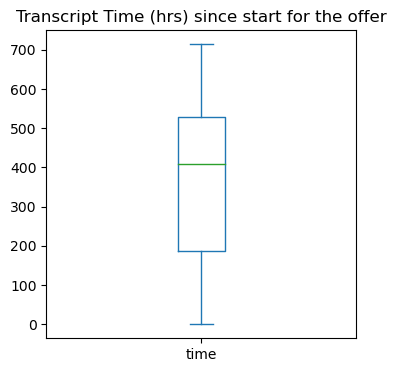

In [55]:
# boxplot for outliers in time variable
transcript["time"].plot.box(
    title="Transcript Time (hrs) since start for the offer", figsize=(4, 4))

#### Based on the boxplot above, we don't see any outliers in the time varaiable.

In [56]:
# Let's get value counts for event.
print("event Unique Value Counts:\n", transcript["event"].value_counts())

event Unique Value Counts:
 transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64


In [57]:
# split the transcript DF into 4 distinct dataframes based on event types, transaction,
# offer received, offer viewed, offer completed

purchasedf1 = transcript[transcript['event'] == 'transaction']
info_on_df(purchasedf1)

offer_received_df1 = transcript[transcript['event'] == 'offer received']
info_on_df(offer_received_df1)

offer_viewed_df1 = transcript[transcript['event'] == 'offer viewed']
info_on_df(offer_viewed_df1)

offer_completed_df1 = transcript[transcript['event'] == 'offer completed']
info_on_df(offer_completed_df1)

------------------------------------
Shape of DataFrame: (138953, 4)
Columns of DataFrame: Index(['person', 'event', 'value', 'time'], dtype='object')
------------------------------------
Shape of DataFrame: (76277, 4)
Columns of DataFrame: Index(['person', 'event', 'value', 'time'], dtype='object')
------------------------------------
Shape of DataFrame: (57725, 4)
Columns of DataFrame: Index(['person', 'event', 'value', 'time'], dtype='object')
------------------------------------
Shape of DataFrame: (33579, 4)
Columns of DataFrame: Index(['person', 'event', 'value', 'time'], dtype='object')


In [58]:
def expand_dict_column(df, column_name):
    """
    This function expands a column of dictionaries in a DataFrame to multiple columns in the same DataFrame.
    Args:
    - df: a pandas DataFrame containing the column to be expanded
    - column_name: the name of the column to be expanded
    Returns:
    - A pandas DataFrame with the expanded columns from the dictionary.
    """
    printf("\n----In function expand_dict_column------\n")
    df.reset_index(inplace=True, drop=True)
    printf("Before df shape=", df.shape)

    # convert the column of dictionaries to a DataFrame
    # df_expanded = df.from_records(df[column_name]) also works; revisit later
    df_expanded = pd.json_normalize(df[column_name])
    df_expanded.reset_index(inplace=True, drop=True)
    printf("df_expanded shape=", df_expanded.shape)

    # concatenate the expanded DataFrame with the original DataFrame
    df = pd.concat([df, df_expanded], axis=1)
    printf("After df shape=", df.shape)

    # check if any columns have the same name as the expanded columns and rename them
    expanded_columns = df_expanded.columns
    for col in expanded_columns:
        if col in df.columns and col != column_name:
            df = df.rename(columns={col: f"{column_name}_{col}"})

    # drop the original column
    df = df.drop(column_name, axis=1)
    printf("\n----Exiting function expand_dict_column------\n")
    return df

## Let's work on purchase event data:

In [59]:
# reset index on purchase1 and # drop the event column since we already know what each df is
purchasedf2 = purchasedf1.reset_index(drop=True)
purchasedf2.drop(["event"], axis=1, inplace=True)

In [60]:
# Let's see if there are any missing values in purchasedf2
create_missing_values_table(purchasedf2)

Your selected dataframe has 3 columns.
There are 0 columns that have missing values.


,DataTypes,Missing Values,% of Total Values


In [61]:
# expand the value dict column to multiple column using function above
PRINT = True
purchasedf3 = expand_dict_column(purchasedf2, 'value')
info_on_df(purchasedf3)

# rename value_amount to purchase_amount
purchasedf3.rename(columns={'value_amount': 'purchase_amount'}, inplace=True)
print(purchasedf3.info())


----In function expand_dict_column------

Before df shape= (138953, 3)
df_expanded shape= (138953, 1)
After df shape= (138953, 4)

----Exiting function expand_dict_column------

------------------------------------
Shape of DataFrame: (138953, 3)
Columns of DataFrame: Index(['person', 'time', 'value_amount'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138953 entries, 0 to 138952
Data columns (total 3 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   person           138953 non-null  object 
 1   time             138953 non-null  int64  
 2   purchase_amount  138953 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 3.2+ MB
None


In [62]:
# drop index column
# purchasedf3.drop(['index'], axis=1, inplace=True)

In [63]:
# let's get a reportin on missing values on purchasedf2
create_missing_values_table(purchasedf3)

Your selected dataframe has 3 columns.
There are 0 columns that have missing values.


,DataTypes,Missing Values,% of Total Values


In [64]:
# Get the total purchase amount before removing rows with missing values
print("purchasedf3 Total purchase amount = ",
      round(purchasedf3["purchase_amount"].sum(), 2))

purchasedf3 Total purchase amount =  1775451.97


In [65]:
# let's get summary stats
purchasedf3.describe(include='all')

,person,time,purchase_amount
count,138953,138953.000000,138953.000000
unique,16578,NaN,NaN
top,79d9d4f86aca4bed9290350fb43817c2,NaN,NaN
freq,36,NaN,NaN
mean,NaN,381.584334,12.777356
std,NaN,201.697230,30.250529
min,NaN,0.000000,0.050000
25%,NaN,210.000000,2.780000
50%,NaN,402.000000,8.890000
75%,NaN,552.000000,18.070000


#### We see above purchase_amount range from 0 to 1062, there are definitely some outliers since who purchases \$1062 worth of coffee? 

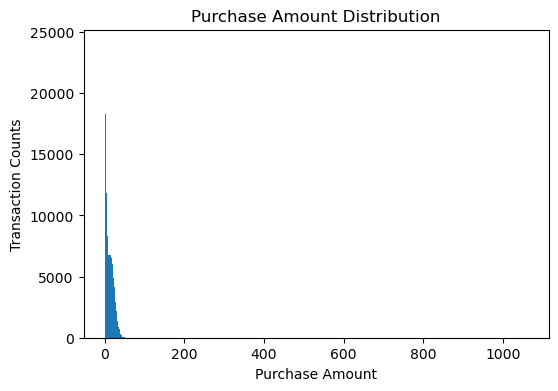

In [66]:
# Plot histogram of purchase_amount distribution
fig, ax = plt.subplots(figsize=(6, 4))
ax.hist(purchasedf3["purchase_amount"], bins=600)
ax.set_xlabel('Purchase Amount')
ax.set_ylabel('Transaction Counts')
ax.set_title('Purchase Amount Distribution')
plt.show()

<AxesSubplot: title={'center': 'Purchase Amount Boxplot'}>

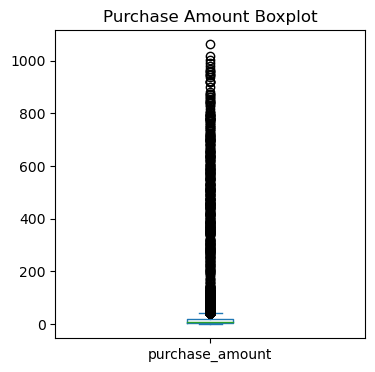

In [67]:
# we see purchase_amount range from 0 to 1062, suspect outliers.
purchasedf3["purchase_amount"].plot.box(figsize=(4, 4),
                                        title="Purchase Amount Boxplot")

 ### Outliers in purchase_amount warrants special mention since obviously there are outliers. Majority of the records in transcript dataset have 0 purchase amount, which we may need later. We have 3 options:
1) Remove the outliers in purchase_amount in first dataframe.
 purchasedf_clean = remove_purchase_outliers(purchasedf3, "purchase_amount")
2) Records with huge purchase amounts, can be filtered out using high range limit.
 purchasedf_clean = purchasedf3[purchasedf3["purchase_amount"] <= purchase_high_limit]
3) Alternate approach is to remove outliers from subsequent dataframes when we split the purchases as qualified, unqualified and purchase-w/o-offer into separate dataframes

### We will go with the third option, to remove outliers from subsequent dataframes when we split the purchase dataset.

In [68]:
# let's round the purchase_amount; copy is needed to avoid warning
purchasedf_clean = purchasedf3.copy()  ## leaving all outlier data with this

purchasedf_clean['purchase_amount'] = purchasedf_clean[
    'purchase_amount'].round(2)

purchasedf_clean["purchase_amount"].describe()

# show purchase_amount on histogram
# counts, edges, bars = plt.hist(purchasedf_clean["purchase_amount"], bins=18)
# plt.xlabel("Purchase Amount")
# plt.ylabel('Transaction Counts')
# plt.title("purchasedf_clean purchase_amount Distribution after removing outliers")
# plt.bar_label(bars)

# Get the total purchase amount
print("purchasedf_clean Total purchase amount = ",
      round(purchasedf_clean["purchase_amount"].sum(), 2))

purchasedf_clean Total purchase amount =  1775451.97


<AxesSubplot: title={'center': 'purchasedf_clean time Boxplot'}>

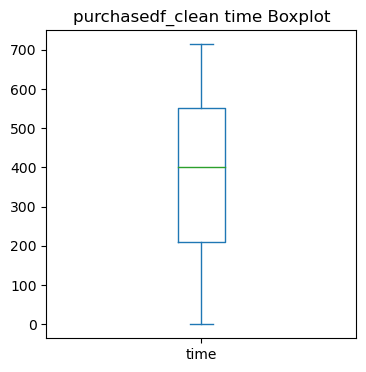

In [69]:
# Let's see how time variable looks
purchasedf_clean["time"].plot.box(figsize=(4, 4),
                                  title="purchasedf_clean time Boxplot")

In [70]:
# verify there are no missing values in purchasedf_clean
create_missing_values_table(purchasedf_clean)

Your selected dataframe has 3 columns.
There are 0 columns that have missing values.


,DataTypes,Missing Values,% of Total Values


#### So purchasedf_clean dataframe is in good shape to use for our analysis.
## =====================================================================


# Let's work on cleaning up offer_received_df1

In [71]:
# Create offer_received_df2, without the event column and reset the index
offer_received_df2 = offer_received_df1[['person', 'time', 'value']]
offer_received_df2.reset_index()
offer_received_df2.info()
## offer_received_df2.to_csv("offer_received_df2.csv")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 76277 entries, 0 to 257886
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   person  76277 non-null  object
 1   time    76277 non-null  int64 
 2   value   76277 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.3+ MB


In [72]:
# Let's see if there are any missing values in offer_received_df2
create_missing_values_table(offer_received_df2)

Your selected dataframe has 3 columns.
There are 0 columns that have missing values.


,DataTypes,Missing Values,% of Total Values


In [73]:
# expand the value dict column to multiple column using function above
offer_received_df3 = expand_dict_column(offer_received_df2, 'value')

# offer_received_df3.reset_index()
offer_received_df3.info()


----In function expand_dict_column------

Before df shape= (76277, 3)
df_expanded shape= (76277, 1)
After df shape= (76277, 4)

----Exiting function expand_dict_column------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76277 entries, 0 to 76276
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   person          76277 non-null  object
 1   time            76277 non-null  int64 
 2   value_offer id  76277 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [74]:
# The value dictionary expansion went well; remove space to "value_offer id" by rename
offer_received_df3.rename(columns={"value_offer id": 'value_offer_id'},
                          inplace=True)
info_on_df(offer_received_df3)

# let's get a report on missing values on offer_received_df3
create_missing_values_table(offer_received_df3)

------------------------------------
Shape of DataFrame: (76277, 3)
Columns of DataFrame: Index(['person', 'time', 'value_offer_id'], dtype='object')
Your selected dataframe has 3 columns.
There are 0 columns that have missing values.


,DataTypes,Missing Values,% of Total Values


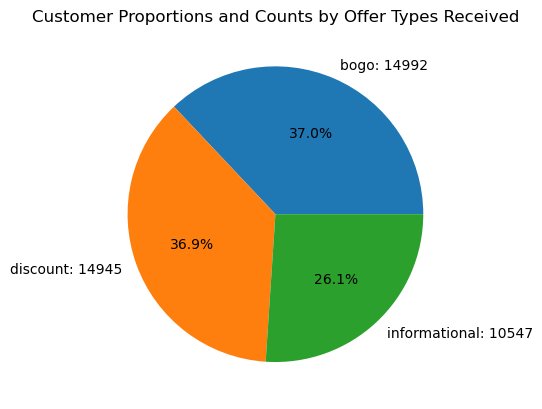

In [75]:
# Show how many persons recieved what type of offer
# let's merge offer_received_df3 with portfolio_clean on offer ids to get offer details
offer_received_df3a = offer_received_df3.merge(portfoliodf1,
                                               how='left',
                                               left_on=["value_offer_id"],
                                               right_on=["id"])

# drop the id column from offer_received_df4
offer_received_df3a.drop(["id"], axis=1, inplace=True)
# info_on_df(offer_received_df3a)

# group the data and calculate the counts
count_by_offer = offer_received_df3a.groupby('offer_type')['person'].nunique()
total_count = count_by_offer.sum()

# calculate the percentages and labels
labels = [
    f"{label}: {count}"
    for label, count in zip(count_by_offer.index, count_by_offer)
]

# create the pie chart
plt.pie(count_by_offer, labels=labels, autopct='%1.1f%%')
plt.title('Customer Proportions and Counts by Offer Types Received')
plt.show()

In [76]:
# let's merge offer_received_df3 with portfolio_clean on offer ids to get offer details
offer_received_df4 = offer_received_df3.merge(portfoliodf_clean,
                                              how='left',
                                              left_on=["value_offer_id"],
                                              right_on=["id"])

# drop the id column from offer_received_df4
offer_received_df4.drop(["id"], axis=1, inplace=True)
info_on_df(offer_received_df4)

------------------------------------
Shape of DataFrame: (76277, 13)
Columns of DataFrame: Index(['person', 'time', 'value_offer_id', 'reward', 'difficulty', 'duration',
       'social', 'web', 'mobile', 'email', 'OfrTyp_bogo', 'OfrTyp_discount',
       'OfrTyp_informational'],
      dtype='object')


In [77]:
# let's get a report on missing values on offer_received_df4
create_missing_values_table(offer_received_df4)

Your selected dataframe has 13 columns.
There are 0 columns that have missing values.


,DataTypes,Missing Values,% of Total Values


In [78]:
# now that offer_received_df3 looks good, let's copy it to _clean
offer_receiveddf_clean = offer_received_df4.copy()

In [79]:
# how many unique persons in offer_receiveddf_clean
offer_receiveddf_clean['person'].unique().shape

(16994,)

### We now have cleaned purchase data (purchasedf_clean) and offer received ( offer_receiveddf_clean), we can tag the purchases as qualified, unqualified or without-offer. There are 5 groups of customers, we can think of:

- Customers who received offers and purchased within the offer duration >> qualified purchases, this is our target demographics.
- Customers who received offers and purchased outside the offer duration >> unqualified purchases, should we send offers to these customers, yes!
- Customers who did NOT receive any offers and purchased anyways >> without-offer purchases, we may send offers to these customers, to encourage more purchase
- Customers who received offers and did NOT purchase at all >> Offers Given No purchases, should we send offers to these customers, yes!
- Customers who did NOT receive offers and did NOT purchase >> we need not send offers to these customers.

In [80]:
# full volume test of the splitting the purchases
OfferDF = offer_receiveddf_clean
purchaseDF = purchasedf_clean
print("\n purchaseDF Total purchase amount = ",
      round(purchaseDF["purchase_amount"].sum(), 2))


 purchaseDF Total purchase amount =  1775451.97


In [81]:
# Create qualified offers dataframe, for purchases within the offer duration window
qualified_offers = OfferDF.merge(purchaseDF,
                                 on=['person'],
                                 suffixes=('_offer', '_purchase'))
# qualified_offers.info()
qualified_offers = qualified_offers[(qualified_offers['time_purchase'].between(
    qualified_offers['time_offer'],
    qualified_offers['time_offer'] + qualified_offers['duration']))]

qualified_offers.drop(['time_offer'], axis=1, inplace=True)
qualified_offers.rename(columns={'time_purchase': 'time'}, inplace=True)

qualified_offers['purchase_type'] = 'qualified'

print("qualified_offers=\n", qualified_offers.info())

print("\n qualified_offers Total purchase amount   = ",
      qualified_offers["purchase_amount"].sum())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8661 entries, 294 to 638450
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   person                8661 non-null   object 
 1   value_offer_id        8661 non-null   object 
 2   reward                8661 non-null   int64  
 3   difficulty            8661 non-null   int64  
 4   duration              8661 non-null   int64  
 5   social                8661 non-null   int64  
 6   web                   8661 non-null   int64  
 7   mobile                8661 non-null   int64  
 8   email                 8661 non-null   int64  
 9   OfrTyp_bogo           8661 non-null   uint8  
 10  OfrTyp_discount       8661 non-null   uint8  
 11  OfrTyp_informational  8661 non-null   uint8  
 12  time                  8661 non-null   int64  
 13  purchase_amount       8661 non-null   float64
 14  purchase_type         8661 non-null   object 
dtypes: float64(1), in

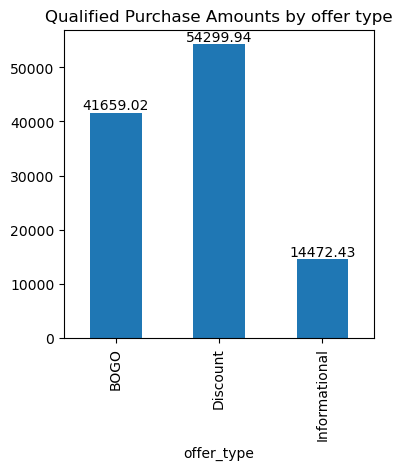

In [82]:
# Analyze purchase amount by offer type
QDF = qualified_offers.copy()
QDF['offer_type'] = np.where(
    QDF['OfrTyp_bogo'] == 1, 'BOGO',
    np.where(QDF['OfrTyp_discount'] == 1, 'Discount', 'Informational'))
QDF = QDF.groupby('offer_type')['purchase_amount'].sum()

# Plot the purchase amounts by offer type
ax = QDF.plot(kind='bar',
              figsize=(4, 4),
              title='Qualified Purchase Amounts by offer type')
for i, v in enumerate(QDF.values):
    ax.annotate(str(v), xy=(i, v), ha='center', va='bottom')
plt.show()

In [83]:
# Find purchases without receiving any offers
# Get the list of persons that received the offer
persons_to_exclude = OfferDF['person'].unique()

# Filter the purchase records where person is not in the above list
purchaseWOOffer = purchaseDF[~purchaseDF["person"].isin(persons_to_exclude)]

print("\n Purchase w/o offer, total purchase amount   = ",
      purchaseWOOffer["purchase_amount"].sum())

purchaseWOOffer.info()


 Purchase w/o offer, total purchase amount   =  250.61
<class 'pandas.core.frame.DataFrame'>
Int64Index: 20 entries, 894 to 127874
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   person           20 non-null     object 
 1   time             20 non-null     int64  
 2   purchase_amount  20 non-null     float64
dtypes: float64(1), int64(1), object(1)
memory usage: 640.0+ bytes


In [84]:
# let's create purchaseDFQual for identifying unqualified purchases
purchaseDFQual = qualified_offers[['person', 'time', 'purchase_amount']]
purchaseDFQual.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8661 entries, 294 to 638450
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   person           8661 non-null   object 
 1   time             8661 non-null   int64  
 2   purchase_amount  8661 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 270.7+ KB


In [85]:
# combine purchaseDFQual and purchaseWOOffer into one dataframe
purchaseDFQualWOOffer = pd.concat([purchaseWOOffer, purchaseDFQual], axis=0)

info_on_df(purchaseDFQualWOOffer)

------------------------------------
Shape of DataFrame: (8681, 3)
Columns of DataFrame: Index(['person', 'time', 'purchase_amount'], dtype='object')


#### Now we need to subtract purchaseDFQualWOOffer rows from the purchaseDF, which will give the unqualified_purchase_DF.

In [86]:
# Merge the purchasedf and qualpurch dataframes
merged = purchaseDF.merge(purchaseDFQualWOOffer,
                          on=['person', 'time', 'purchase_amount'],
                          how='outer',
                          indicator=True)

# Select the rows that are only in the purchasedf dataframe
unqualified_purchase_DF = merged[merged['_merge'] == 'left_only'][[
    'person', 'time', 'purchase_amount'
]]

# print(unqualified_purchase_DF)
print("\nUnqualified_purchase_DF, total purchase amount   = ",
      unqualified_purchase_DF["purchase_amount"].sum())


Unqualified_purchase_DF, total purchase amount   =  1664769.97


In [87]:
# validate the splits of purchases amounts equate to the starting total purchase amount:
purchaseDF_total_purchase = round(purchaseDF["purchase_amount"].sum(), 2)

sum_of_splits_total_purchase = round(
    qualified_offers["purchase_amount"].sum() +
    purchaseWOOffer["purchase_amount"].sum() +
    unqualified_purchase_DF["purchase_amount"].sum(), 2)

print("purchaseDF_total_purchase=", purchaseDF_total_purchase,
      ", sum_of_splits_total_purchase=", sum_of_splits_total_purchase,
      " >> Matched = ",
      purchaseDF_total_purchase == sum_of_splits_total_purchase)

purchaseDF_total_purchase= 1775451.97 , sum_of_splits_total_purchase= 1775451.97  >> Matched =  True


#### Let's find out Customers received offers and did NOT purchase at all

In [88]:
# receiving offers but did not make any purchases
# First get a list of persons that made any purchase anytime
persons_to_exclude = purchaseDF['person'].unique()

# Filter the offer records where person is not in the above list
OfferWOPurchaseDF = OfferDF[~OfferDF["person"].isin(persons_to_exclude)]

OfferWOPurchaseDF.info()

print("No of persons who received offers but did not make any purchases=",
      OfferWOPurchaseDF['person'].unique().shape[0])

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1881 entries, 3 to 76180
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   person                1881 non-null   object
 1   time                  1881 non-null   int64 
 2   value_offer_id        1881 non-null   object
 3   reward                1881 non-null   int64 
 4   difficulty            1881 non-null   int64 
 5   duration              1881 non-null   int64 
 6   social                1881 non-null   int64 
 7   web                   1881 non-null   int64 
 8   mobile                1881 non-null   int64 
 9   email                 1881 non-null   int64 
 10  OfrTyp_bogo           1881 non-null   uint8 
 11  OfrTyp_discount       1881 non-null   uint8 
 12  OfrTyp_informational  1881 non-null   uint8 
dtypes: int64(8), object(2), uint8(3)
memory usage: 167.2+ KB
No of persons who received offers but did not make any purchases= 422


#### Find customers in Profile dataset that did NOT receive offers and did NOT purchase:

In [89]:
# Customers who did NOT receive offers and did NOT purchase
# First get a list of persons in profileDF
persons_to_exclude = profileDF_clean['id'].unique()
print("\n Unique no of persons in profile DF:", persons_to_exclude.shape[0])

# Filter the offer records where person is not in the profile list
custInProfileNotInOfferDF = OfferDF[~OfferDF["person"].isin(persons_to_exclude
                                                            )]

info_on_df(custInProfileNotInOfferDF)

print("No of persons in profile but not receiving offers =",
      custInProfileNotInOfferDF['person'].unique().shape[0])

# Filter the purchase records where person is not in the profile list
custInProfileNotInPurchaseDF = purchaseDF[~purchaseDF["person"].
                                          isin(persons_to_exclude)]

info_on_df(custInProfileNotInPurchaseDF)

print(
    "No of persons in profile but not in purchase dataset (not making any purchases)=",
    custInProfileNotInPurchaseDF['person'].unique().shape[0])


 Unique no of persons in profile DF: 17000
------------------------------------
Shape of DataFrame: (0, 13)
Columns of DataFrame: Index(['person', 'time', 'value_offer_id', 'reward', 'difficulty', 'duration',
       'social', 'web', 'mobile', 'email', 'OfrTyp_bogo', 'OfrTyp_discount',
       'OfrTyp_informational'],
      dtype='object')
No of persons in profile but not receiving offers = 0
------------------------------------
Shape of DataFrame: (0, 3)
Columns of DataFrame: Index(['person', 'time', 'purchase_amount'], dtype='object')
No of persons in profile but not in purchase dataset (not making any purchases)= 0


In [90]:
def plot_histogram(df, title):
    """
    Plots histogram using DataFrame and gives passed Title.
    Parameters:
    df : The DataFrame containing the data to plot histogram.
    title: str, title of the histgram.
    Returns: none.
    """
    counts, edges, bars = plt.hist(df["purchase_amount"], bins=18)
    plt.xlabel("Purchase Amount")
    plt.ylabel('Transaction Counts')
    plt.title(title)
    plt.bar_label(bars)


Before removing outliers from qualified_offers:
count    8661.000000
mean       12.750420
std        28.285736
min         0.050000
25%         2.830000
50%         9.100000
75%        18.230000
max       881.350000
Name: purchase_amount, dtype: float64

---In function remove_purchase_outliers ---

------------------------------------
Shape of DataFrame: (8661, 15)
Columns of DataFrame: Index(['person', 'value_offer_id', 'reward', 'difficulty', 'duration',
       'social', 'web', 'mobile', 'email', 'OfrTyp_bogo', 'OfrTyp_discount',
       'OfrTyp_informational', 'time', 'purchase_amount', 'purchase_type'],
      dtype='object')
------------------------------------
Shape of DataFrame: (8587, 15)
Columns of DataFrame: Index(['person', 'value_offer_id', 'reward', 'difficulty', 'duration',
       'social', 'web', 'mobile', 'email', 'OfrTyp_bogo', 'OfrTyp_discount',
       'OfrTyp_informational', 'time', 'purchase_amount', 'purchase_type'],
      dtype='object')

---Leaving function remove

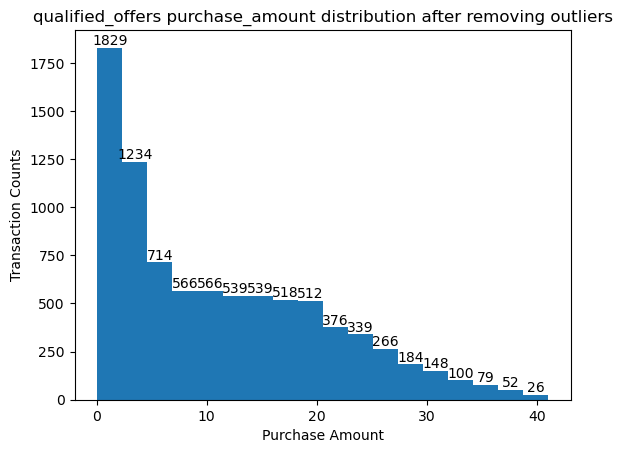


Before removing outliers from purchaseWOOffer:
count    20.000000
mean     12.530500
std       9.577654
min       0.350000
25%       4.340000
50%      10.625000
75%      18.985000
max      28.700000
Name: purchase_amount, dtype: float64

---In function remove_purchase_outliers ---

------------------------------------
Shape of DataFrame: (20, 3)
Columns of DataFrame: Index(['person', 'time', 'purchase_amount'], dtype='object')
------------------------------------
Shape of DataFrame: (20, 3)
Columns of DataFrame: Index(['person', 'time', 'purchase_amount'], dtype='object')

---Leaving function remove_purchase_outliers ---


After removing outliers from purchaseWOOffer:
count    20.000000
mean     12.530500
std       9.577654
min       0.350000
25%       4.340000
50%      10.625000
75%      18.985000
max      28.700000
Name: purchase_amount, dtype: float64

Total purchase amount in purchaseWOOffer after removing outliers: 250.61


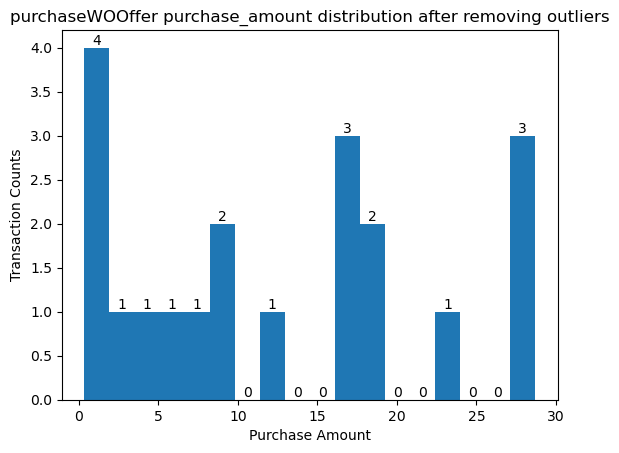


Before removing outliers from unqualified_purchase_DF:
count    130272.000000
mean         12.779185
std          30.378844
min           0.050000
25%           2.777500
50%           8.870000
75%          18.060000
max        1062.280000
Name: purchase_amount, dtype: float64

---In function remove_purchase_outliers ---

------------------------------------
Shape of DataFrame: (130272, 3)
Columns of DataFrame: Index(['person', 'time', 'purchase_amount'], dtype='object')
------------------------------------
Shape of DataFrame: (129109, 3)
Columns of DataFrame: Index(['person', 'time', 'purchase_amount'], dtype='object')

---Leaving function remove_purchase_outliers ---


After removing outliers from unqualified_purchase_DF:
count    129109.000000
mean         11.088913
std           9.404676
min           0.050000
25%           2.740000
50%           8.710000
75%          17.790000
max          40.980000
Name: purchase_amount, dtype: float64

Total purchase amount in unqualified_purcha

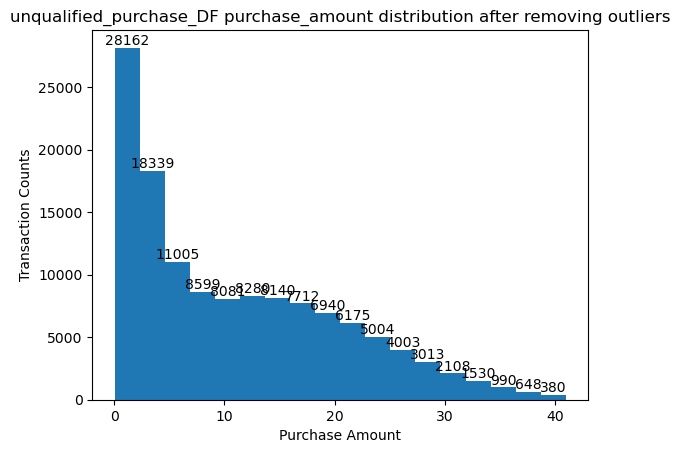

In [91]:
# 3/26 11:30AM # remove outliers from each of the three DFs
# Store DFs in a list
dfs = [qualified_offers, purchaseWOOffer, unqualified_purchase_DF]

# repeat for each DF
for i, df in enumerate(dfs):
    df_name = [
        'qualified_offers', 'purchaseWOOffer', 'unqualified_purchase_DF'
    ][i]
    print(f"\nBefore removing outliers from {df_name}:")
    print(df["purchase_amount"].describe())

    # call the the function to remove outliers
    df_wo_outliers = remove_purchase_outliers(df, "purchase_amount")

    print(f"\nAfter removing outliers from {df_name}:")
    print(df_wo_outliers["purchase_amount"].describe())

    print(
        f"\nTotal purchase amount in {df_name} after removing outliers: {df_wo_outliers['purchase_amount'].sum()}"
    )

    # call the the function to plot histogram
    plot_histogram(
        df_wo_outliers,
        f"{df_name} purchase_amount distribution after removing outliers")
    plt.show()

In [92]:
# outlier removing option looks good so lets replace the DFs
qualified_offers = remove_purchase_outliers(qualified_offers,
                                            "purchase_amount")
purchaseWOOffer = remove_purchase_outliers(purchaseWOOffer, "purchase_amount")
unqualified_purchase_DF = remove_purchase_outliers(unqualified_purchase_DF,
                                                   "purchase_amount")


---In function remove_purchase_outliers ---

------------------------------------
Shape of DataFrame: (8661, 15)
Columns of DataFrame: Index(['person', 'value_offer_id', 'reward', 'difficulty', 'duration',
       'social', 'web', 'mobile', 'email', 'OfrTyp_bogo', 'OfrTyp_discount',
       'OfrTyp_informational', 'time', 'purchase_amount', 'purchase_type'],
      dtype='object')
------------------------------------
Shape of DataFrame: (8587, 15)
Columns of DataFrame: Index(['person', 'value_offer_id', 'reward', 'difficulty', 'duration',
       'social', 'web', 'mobile', 'email', 'OfrTyp_bogo', 'OfrTyp_discount',
       'OfrTyp_informational', 'time', 'purchase_amount', 'purchase_type'],
      dtype='object')

---Leaving function remove_purchase_outliers ---


---In function remove_purchase_outliers ---

------------------------------------
Shape of DataFrame: (20, 3)
Columns of DataFrame: Index(['person', 'time', 'purchase_amount'], dtype='object')
------------------------------------


### Now let's merge all three purchase dataframes so that can be used in the models:

# keeping all vars from qualified_offers 

In [93]:
# qualified_offers with aggrgated purchase amount
pqualdf = qualified_offers
info_on_df(pqualdf)

# purchaseWOOffer with aggrgated purchase amount; add the required columns with default values
pWfrdf = pd.DataFrame({
    'person':
    purchaseWOOffer['person'].unique(),
    'value_offer_id':
    0,
    'reward':
    0,
    'difficulty':
    0,
    'duration':
    0,
    'email':
    0,
    'social':
    0,
    'mobile':
    0,
    'web':
    0,
    'OfrTyp_bogo':
    0,
    'OfrTyp_discount':
    0,
    'OfrTyp_informational':
    0,
    'time':
    0,
    'purchase_amount':
    purchaseWOOffer.groupby('person')['purchase_amount'].sum().values,
    'purchase_type':
    'withoutOffer'
})
info_on_df(pWfrdf)

# unqualified_purchase_DF with aggrgated purchase amount
punqdf = pd.DataFrame({
    'person':
    unqualified_purchase_DF['person'].unique(),
    'value_offer_id':
    0,
    'reward':
    0,
    'difficulty':
    0,
    'duration':
    0,
    'email':
    0,
    'social':
    0,
    'mobile':
    0,
    'web':
    0,
    'OfrTyp_bogo':
    0,
    'OfrTyp_discount':
    0,
    'OfrTyp_informational':
    0,
    'time':
    0,
    'purchase_amount':
    unqualified_purchase_DF.groupby('person')['purchase_amount'].sum().values,
    'purchase_type':
    'unqualified'
})
info_on_df(punqdf)

# Concatenate all three into one df
tagged_purchaseDF = pd.concat([pqualdf, pWfrdf, punqdf], axis=0)
tagged_purchaseDF.reset_index(inplace=True, drop=True)
tagged_purchaseDF.info()

# 3/25 7pm Keep this section for now Convert purchase_type categorical var to dummies
# tagged_purchaseDF_temp = pd.concat(
#    [tagged_purchaseDF,
#     pd.get_dummies(tagged_purchaseDF["purchase_type"], prefix='purchase')],
#    axis=1)
# tagged_purchaseDF_clean = tagged_purchaseDF_temp.drop(['purchase_type', 'time'], axis=1)

tagged_purchaseDF_clean = tagged_purchaseDF.drop(['time'], axis=1)

print("\ntagged_purchaseDF_clean.info:")
tagged_purchaseDF_clean.info()

print("\ntagged_purchaseDF_clean sums:")
tagged_purchaseDF_clean.sum(numeric_only=True)

------------------------------------
Shape of DataFrame: (8587, 15)
Columns of DataFrame: Index(['person', 'value_offer_id', 'reward', 'difficulty', 'duration',
       'social', 'web', 'mobile', 'email', 'OfrTyp_bogo', 'OfrTyp_discount',
       'OfrTyp_informational', 'time', 'purchase_amount', 'purchase_type'],
      dtype='object')
------------------------------------
Shape of DataFrame: (6, 15)
Columns of DataFrame: Index(['person', 'value_offer_id', 'reward', 'difficulty', 'duration', 'email',
       'social', 'mobile', 'web', 'OfrTyp_bogo', 'OfrTyp_discount',
       'OfrTyp_informational', 'time', 'purchase_amount', 'purchase_type'],
      dtype='object')
------------------------------------
Shape of DataFrame: (16536, 15)
Columns of DataFrame: Index(['person', 'value_offer_id', 'reward', 'difficulty', 'duration', 'email',
       'social', 'mobile', 'web', 'OfrTyp_bogo', 'OfrTyp_discount',
       'OfrTyp_informational', 'time', 'purchase_amount', 'purchase_type'],
      dtype='obj

reward                    37475.00
difficulty                72732.00
duration                  60198.00
social                     5336.00
web                        6888.00
mobile                     7716.00
email                      8587.00
OfrTyp_bogo                3288.00
OfrTyp_discount            4243.00
OfrTyp_informational       1056.00
purchase_amount         1528265.62
dtype: float64

In [94]:
# tagged_purchaseDF_clean[tagged_purchaseDF_clean['purchase_unqualified']==1]
# tagged_purchaseDF_clean['purchase_amount'].sum()
tagged_purchaseDF_clean.describe(include='all')

,person,value_offer_id,reward,difficulty,duration,social,web,mobile,email,OfrTyp_bogo,OfrTyp_discount,OfrTyp_informational,purchase_amount,purchase_type
count,25129,25129.0,25129.000000,25129.000000,25129.000000,25129.000000,25129.000000,25129.000000,25129.000000,25129.000000,25129.000000,25129.000000,25129.000000,25129
unique,16573,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
top,86e9d338b85b4177b369fe6b0ad4fed3,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,unqualified
freq,7,16542.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16536
mean,NaN,NaN,1.491305,2.894345,2.395559,0.212344,0.274106,0.307056,0.341717,0.130845,0.168849,0.042023,60.816810,NaN
std,NaN,NaN,2.811721,4.996785,3.540293,0.408975,0.446071,0.461282,0.474295,0.337237,0.374626,0.200646,72.481081,NaN
min,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.050000,NaN
25%,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.290000,NaN
50%,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25.520000,NaN
75%,NaN,NaN,2.000000,5.000000,7.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,94.710000,NaN


# ------------------------------------------------------------------------------------
# Combine tagged purchase data with customer profile data

In [95]:
# merge tagged_purchaseDF_clean with profiledf4
combineddf1 = tagged_purchaseDF_clean.merge(profiledf4,
                                            how='inner',
                                            left_on=["person"],
                                            right_on=["id"],
                                            sort=True)
combineddf1.reset_index(inplace=True, drop=True)

# drop the id column since we are keeping person column
combineddf1.drop(['id'], axis=1, inplace=True)

print(combineddf1.shape)
print("Total purchase Amount in combineddf1 =",
      combineddf1['purchase_amount'].sum())

# Let's see if there are any missing values in combineddf1
create_missing_values_table(combineddf1)

# Save combineddf1 to csv file
combineddf1.to_csv("combineddf1.csv")

(25129, 67)
Total purchase Amount in combineddf1 = 1528265.62
Your selected dataframe has 67 columns.
There are 0 columns that have missing values.


<AxesSubplot: title={'center': 'Purchase Amounts by cluster stacked by Purchase Type'}, xlabel='cluster'>

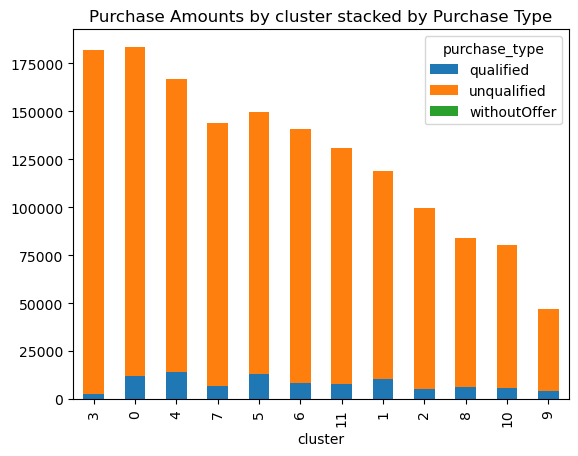

In [96]:
# Analyze combineddf1 that has customer profile and purchase data by plotting
purch_by_cluster = combineddf1.groupby(['cluster', 'purchase_type'
                                        ])['purchase_amount'].sum()
purch_by_cluster = purch_by_cluster.unstack()

# print(purch_by_cluster.columns)
purch_by_cluster = purch_by_cluster.sort_values(by='unqualified',
                                                ascending=False)
purch_by_cluster.plot(kind='bar',
                      stacked=True,
                      title='Purchase Amounts by cluster stacked by Purchase Type')

#### Cluster 0 has the total highest purchase, followed by cluster 3 and 4. We have already seen the make-up of these clusters earlier. 

In [97]:
def keep_numeric_columns(df):
    """
    Utility function to keep only numeric columns in a given dataframe for regression analysis
    Input:
        df (pandas dataframe): the input dataframe from which to keep numeric variables
    Returns:
        df (pandas dataframe): the output dataframe which only contains numeric variables
    """
    numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()
    print("Number of Numeric columns in the dataset = ", len(numeric_columns))

    return df[numeric_columns]

In [98]:
# Convert purchase_type categorical var to dummies
combineddf2 = pd.concat([
    combineddf1,
    pd.get_dummies(tagged_purchaseDF["purchase_type"], prefix='purchase')
],
                        axis=1)

# Drop purchase_type categorical var since we have dummies
combineddf2.drop(['purchase_type'], axis=1, inplace=True)

info_on_df(combineddf2)

------------------------------------
Shape of DataFrame: (25129, 69)
Columns of DataFrame: Index(['person', 'value_offer_id', 'reward', 'difficulty', 'duration',
       'social', 'web', 'mobile', 'email', 'OfrTyp_bogo', 'OfrTyp_discount',
       'OfrTyp_informational', 'purchase_amount', 'income_0_20k',
       'income_20_30k', 'income_30_40k', 'income_40_50k', 'income_50_60k',
       'income_60_70k', 'income_70_80k', 'income_80_90k', 'income_90_100k',
       'income_100_110k', 'income_110_120k', 'income_120+', 'tenure_days_0_15',
       'tenure_days_15_30', 'tenure_days_30_45', 'tenure_days_45_60',
       'tenure_days_60_75', 'tenure_days_75_90', 'tenure_days_90_105',
       'tenure_days_105_120', 'tenure_days_120_135', 'tenure_days_135_150',
       'tenure_days_150_165', 'tenure_days_165_180', 'tenure_days_180_195',
       'tenure_days_195_210', 'tenure_days_210_225', 'tenure_days_225_240',
       'tenure_days_240_255', 'tenure_days_255_270', 'tenure_days_270_285',
       'tenure_days

In [99]:
# Since we already have the clusters assigned using the demographics attributes, we can only use the clusters and drop
# other attributes.
combineddf3cluster = combineddf2[[
    'cluster', 'reward', 'difficulty', 'duration', 'social', 'mobile', 'email',
    'web', 'OfrTyp_bogo', 'OfrTyp_discount', 'OfrTyp_informational',
    'purchase_qualified', 'purchase_unqualified', 'purchase_withoutOffer',
    'purchase_amount'
]]
combineddf3cluster.columns

Index(['cluster', 'reward', 'difficulty', 'duration', 'social', 'mobile',
       'email', 'web', 'OfrTyp_bogo', 'OfrTyp_discount',
       'OfrTyp_informational', 'purchase_qualified', 'purchase_unqualified',
       'purchase_withoutOffer', 'purchase_amount'],
      dtype='object')

# ----------------------------------------------------------------------------------------------------

# 4. Modeling
Now that we have completed data preprocessing, we will select models for each the business question. To find factors that determine purchase amount, which is a numerical response variable, we will consider two regression models,

* Linear Regression with recursive approach to find the best variables for the model,
* LassoCV that will eliminate variables and also perform five-fold cross-validation. We will evaluate model performance by using the list of variables suggested by these 2 models and run Linear Regression.

Now let's try to find most important columns that can predict purchase amount for a customer.

In [100]:
def select_important_columns(df, responseCol="", featureKnt=60):
    '''
    This function uses feature importance from Linear Regressor to identify the top n columns that are most important for 
    predicting the given response variable. It returns a list of the column names corresponding to the selected columns.
    Input:
        df (pandas dataframe): Dataframe on which to run the LinearRegression model
        responseCol (str): Response variable in the input dataframe
        featureKnt (int): Maximum number of features to return as predictors
    Returns:
        list: List of column names corresponding to the selected columns
    '''

    X = df.drop(responseCol, axis=1)
    y = df[responseCol]
    model = LinearRegression()
    rfe = RFE(model, n_features_to_select=featureKnt)
    rfe.fit(X, y)
    return X.columns[rfe.support_]

In [101]:
# Now let's run the Linear Regression and see what are the important predictors for
# the purchase_amount
numPredictors = 20
importantPredictors = select_important_columns(combineddf3cluster,
                                               "purchase_amount",
                                               numPredictors)

# print top predictors
print("Top ", numPredictors, " Important Predictors of Purchase Amount are:\n",
      list(importantPredictors))

Top  20  Important Predictors of Purchase Amount are:
 ['cluster', 'reward', 'difficulty', 'duration', 'social', 'mobile', 'email', 'web', 'OfrTyp_bogo', 'OfrTyp_discount', 'OfrTyp_informational', 'purchase_qualified', 'purchase_unqualified', 'purchase_withoutOffer']


#### Let's try another model, Lasso Regression with Cross Validation. Lasso Regession is used when number of predictors is high. Cross validation will rotate the data in the train and test sets by splitting it first. First define a function:

In [102]:
def select_predictors_LassoCV(data, response):
    '''
    This function first removes the response variable from the list of predictors, then creates the feature matrix X and
    target variable y. It then initializes the LassoCV model with 5-fold cross-validation and normalization. It then fits
    the model to the data and gets the indices of the non-zero coefficients. Finally, the function returns a list of the
    predictors with non-zero coefficients.
    inputs 
        data = dataframe on which to run the model
        response = response variable
    returns
        list of nonzero_predictors        
    '''
    predictors = data.columns.tolist()
    predictors.remove(response)
    X = data[predictors]
    y = data[response]

    # Initialize the pipeline
    pipeline = Pipeline([('scaler', StandardScaler()),
                         ('lasso', LassoCV(cv=5, precompute=False))])

    # Fit the pipeline to the data
    pipeline.fit(X, y)

    # Get the indices of the non-zero coefficients
    nonzero_coef_indices = np.nonzero(pipeline.named_steps['lasso'].coef_)[0]

    # Get the names of the predictors with non-zero coefficients
    nonzero_predictors = [predictors[i] for i in nonzero_coef_indices]

    return nonzero_predictors

In [103]:
# Lets' call the function above that runs LassoCV.
predictors_list = select_predictors_LassoCV(combineddf3cluster,
                                            "purchase_amount")
print("Important", len(predictors_list),
      " Predictors by Lasso Cross Validation:\n", predictors_list)

Important 7  Predictors by Lasso Cross Validation:
 ['cluster', 'reward', 'difficulty', 'social', 'mobile', 'email', 'purchase_qualified']


### Linear Regression model indicated to use nearly all predictors whereas LassoCV gave only few predictors.

### Let's now start building a regression model to predict the purchase amount and then demographics clusters. We will start with creating train and test data sets.

In [104]:
def create_train_test_datasets(df, response_var):
    '''
    # Keep only the predictors in the X, and response in y and split the data into train and test
    input
    df : DataFrame to be split into train and test datasets 
    response_var : column name in the df
    '''

    X = df.drop([response_var], axis=1)
    print("\nDimensions of X are:", X.ndim)
    print("Shape of X is", X.shape)
    print("Size of X is", X.size)

    # keep only the response variables in y
    # change the response to 1 or 0 for logistics regression # y =  combineddf3_purch_clstrs["value_amount"].apply(lambda q: 1 if q > 0 else 0)
    y = df[response_var]
    print("\nDimensions of y are:", y.ndim)
    print("Shape of y is", y.shape)
    print("Size of y is", y.size)
    printf(y.head())

    # let's split the data as train test
    X_train, X_test, y_train, y_test = train_test_split(X,
                                                        y,
                                                        train_size=0.75,
                                                        random_state=42)

    y_train.columns = [response_var]
    y_test.columns = [response_var]

    # let's check the train test split results
    print("\nX_train Dim are:", X_train.ndim, "Shape=", X_train.shape,
          "Size =", X_train.size)
    print("y_train Dim are:", y_train.ndim, "Shape=", y_train.shape, "Size =",
          y_train.size)
    print("X_test  Dim are:", X_test.ndim, "Shape=", X_test.shape, "Size =",
          X_test.size)
    print("y_test  Dim are:", y_test.ndim, "Shape=", y_test.shape, "Size =",
          y_test.size)

    return X_train, X_test, y_train, y_test

In [161]:
# call the function to create train and test datasets
X_train, X_test, y_train, y_test = create_train_test_datasets(
    combineddf3cluster[[
        'cluster', 'reward', 'difficulty', 'duration', 'social', 'mobile',
        'email', 'web', 'OfrTyp_bogo', 'OfrTyp_discount',
        'OfrTyp_informational', 'purchase_amount'
    ]], "purchase_amount")


Dimensions of X are: 2
Shape of X is (25129, 11)
Size of X is 276419

Dimensions of y are: 1
Shape of y is (25129,)
Size of y is 25129
0    10.27
1    40.18
2     3.52
3    49.61
4    22.90
Name: purchase_amount, dtype: float64

X_train Dim are: 2 Shape= (18846, 11) Size = 207306
y_train Dim are: 1 Shape= (18846,) Size = 18846
X_test  Dim are: 2 Shape= (6283, 11) Size = 69113
y_test  Dim are: 1 Shape= (6283,) Size = 6283


# Q1: Model that predicts how much someone will spend based on demographics and offer type.

### Let's build a RandomForestRegressor model first to predict the purchase amount and the features that are  important in predicting the purchase amount.


 Feature importances for the RandomForestRegressor model
                       feature_importance
cluster                         0.011510
reward                          0.000129
difficulty                      0.000135
duration                        0.509935
social                          0.000079
mobile                          0.000021
email                           0.478075
web                             0.000051
OfrTyp_bogo                     0.000021
OfrTyp_discount                 0.000027
OfrTyp_informational            0.000020


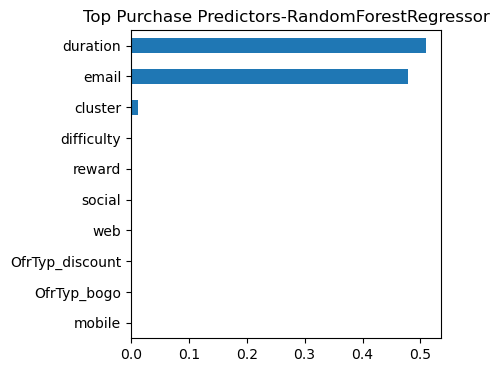

In [162]:
# RandomForestRegressor
clf_rfr = RandomForestRegressor(n_estimators=500,
                                n_jobs=4,
                                random_state=45,
                                verbose=0)
clf_rfr.fit(X_train, y_train)

# Create a dataframe for plotting
clf_rfr_df = pd.DataFrame({"feature_importance": clf_rfr.feature_importances_},
                          index=clf_rfr.feature_names_in_)
# print feature importances for the rfr model
print("\n Feature importances for the RandomForestRegressor model\n", clf_rfr_df)

# Sort feature_importance in descending order of value
clf_rfr_df.sort_values(by="feature_importance", ascending=True, inplace=True)

# plot the chart for Top Purchase Predictors-RandomForestRegressor
clf_rfr_df.tail(10).plot.barh(
    figsize=(4, 4),
    legend=False,
    title="Top Purchase Predictors-RandomForestRegressor")

X_test_combined = pd.concat([X_test, y_test], axis=1)

# Let's predict the test dataset on the RFR model
yPred = clf_rfr.predict(X_test)

### Notice from above chart, according to the Random Forest Regressor model, to predict customer purchase, the top predictors by importance are: offer duration, email as a channel for the offer and customer's demographic cluster. Other predictors importance is realtively very small compared to these top 3. Next we evaluate the RandomForestRegressor model performance:

In [163]:
# calculate mean absolute error, R-squared, and adjusted R-squared for the RandomForestRegressor

# score from the RF model for the training data
clf_rfr.score(X_train, y_train)

# calculate mean squared error
mse = mean_squared_error(y_test, yPred)

# calculate Mean Absolute Error error
mae = abs(yPred - y_test).mean()
r2 = r2_score(y_test, yPred)
n = X_test.shape[0]
p = X_test.shape[1]
adj_r2 = 1 - ((1 - r2) * (n - 1)) / (n - p - 1)
print('RandomForestRegressor Train Data R-squared:', np.round(r2, 2))
print('RandomForestRegressor Test Data R-squared:', np.round(r2, 2))
print('RandomForestRegressor Test Data Mean Absolute Error:', np.round(mae, 2))
print("RandomForestRegressor Test Data Mean Squared Error:", mse)
print('RandomForestRegressor Test Data Adjusted R-squared:',
      np.round(adj_r2, 2))

RandomForestRegressor Train Data R-squared: 0.24
RandomForestRegressor Test Data R-squared: 0.24
RandomForestRegressor Test Data Mean Absolute Error: 44.12
RandomForestRegressor Test Data Mean Squared Error: 3915.592989497273
RandomForestRegressor Test Data Adjusted R-squared: 0.24


### What do these scores mean with RandomForestRegressor model using all predictors?
The R-squared value of **0.24** for both the train and test data means that only **24%** of the variance in the target variable is explained by the features in the model. The Mean Absolute Error of **44.12** indicates that, on average, the model's predictions are off by about **$44.12**. The Adjusted R-squared value of 0.24 is the same as the R-squared value, which means that the addition of the features to the model did not significantly improve the model's fit. In general, an R-squared value of 0.24 is not very high, and the model's performance may be improved by trying different models or feature selection techniques.

To improve the performance of the model on the test data, we can consider tuning the hyperparameters of Random Forest Regressor model, or using a different algorithm altogether. 

We can explore the using the **LassoCV suggested features** to improve the quality model. Perhaps the distribution of the purchase amount in the test dataset is not similar to the distribution in the training dataset, as differences in the distribution can lead to poor model performance.

#### Let's evaluate LassoCV regression model:

In [164]:
# LassoCV regression model
# get the X and y ready

X = combineddf3cluster.copy()
X.drop(["purchase_amount"], axis=1, inplace=True)
print("\nDimensions of X are:", X.ndim)
print("Shape of X is", X.shape)
print("Size of X is", X.size)

# keep only the response variables in y
y = combineddf2["purchase_amount"]
print("\nDimensions of y are:", y.ndim)
print("Shape of y is", y.shape)
print("Size of y is", y.size)
y.head()

# list of predictors
predictors = X.columns.tolist()

# Initialize the pipeline
pipeline = Pipeline([('scaler', StandardScaler()),
                     ('lasso', LassoCV(cv=5, precompute=False))])

# Fit the pipeline to the entire dataset
pipeline.fit(X, y)

# Get the indices of the non-zero coefficients
nonzero_coef_indices = np.nonzero(pipeline.named_steps['lasso'].coef_)[0]

# Get the names of the predictors with non-zero coefficients
nonzero_predictors = [predictors[i] for i in nonzero_coef_indices]

# Find out the r2 score for this LassoCV model
print("\nr^2 score for LassoCV Regression model:", pipeline.score(X, y))

# predict the response variable
y_pred = pipeline.predict(X)

# Compute the mean squared error and R^2 score
mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)

print('LassoCV Regression model Mean Squared Error:', mse)
print('LassoCV Regression model R^2 Score:', r2)


Dimensions of X are: 2
Shape of X is (25129, 14)
Size of X is 351806

Dimensions of y are: 1
Shape of y is (25129,)
Size of y is 25129

r^2 score for LassoCV Regression model: 0.24321728221333994
LassoCV Regression model Mean Squared Error: 3975.605183622484
LassoCV Regression model R^2 Score: 0.24321728221333994


The LassoCV regression model has a **Mean Squared Error of 3975.60**, which indicates that the model has a relatively high error on average. The **R^2 score of 0.24**  indicates that the model explains only about **24%** of the variability in the data, which is relatively low. Overall, the model may not be a good fit for the data, and we may need to consider other models.
The LassoCV Regression model has **R^2 Score of 0.24** which is **same** as what we saw for the **RandomForestRegressor** model earlier.

 ### Let's try Gradient Boosting Regressor model. There are two parameters "learning rate" and "depth" that can be tweaked for better model performance.

In [165]:
# define the function
def train_gbr(X_train,
              y_train,
              X_test,
              y_test,
              learning_rate=0.1,
              n_estimators=100,
              max_depth=3):
    """
    Trains a Gradient Boosting Regressor on the given training data and evaluates its performance on the test data.

    Parameters:
    X_train (numpy.ndarray): Array of shape (n_samples, n_features) containing the training input data.
    y_train (numpy.ndarray): Array of shape (n_samples,) containing the target values for the training data.
    X_test (numpy.ndarray): Array of shape (n_samples, n_features) containing the test input data.
    y_test (numpy.ndarray): Array of shape (n_samples,) containing the target values for the test data.
    learning_rate (float, optional): The learning rate shrinks the contribution of each tree by learning_rate. 
        There is a trade-off between learning_rate and n_estimators.
    n_estimators (int, optional): The number of boosting stages to perform. Gradient boosting is fairly robust 
        to over-fitting so a large number usually results in better performance.
    max_depth (int, optional): Maximum depth of each individual tree estimator.

    Returns:
    (float, float): Tuple containing the mean squared error and R-squared score of the trained model on the test data.
    gnr : Gradient Boosting Regressor model
    """

    # Initialize the Gradient Boosting Regressor
    gbr = GradientBoostingRegressor(learning_rate=learning_rate,
                                    n_estimators=n_estimators,
                                    max_depth=max_depth)

    # Fit the model to the training data
    gbr.fit(X_train, y_train)

    # Evaluate the model on the test data
    y_pred = gbr.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    return mse, r2, gbr

In [166]:
# see if different learning rates yield better performance for the Gradient Boosting Regressor model
print("\nSee if different learning rates yield better performance for the GBR model:")

learning_rates = [0.1, 0.05, 0.01, 0.005]
results = {}

for lr in learning_rates:
    mse, r2, gbr = train_gbr(X_train, y_train, X_test, y_test, lr)
    results[lr] = (mse, r2)

# Sort the results by R^2 score in descending order
sorted_results = sorted(results.items(), key=lambda x: x[1][1], reverse=True)

# Print the results
for lr, (mse, r2) in sorted_results:
    print(
        f"GBR Learning Rate: {lr}, Mean Squared Error: {mse}, R^2 Score: {r2}")

print("\nSee if different depths yield better performance for the GBR model:")
# see if different depths yield better performance for the Gradient Boosting Regressor model
depths = [3, 4, 5, 6, 7, 8]
results = {}

for dp in depths:
    mse, r2, gbr = train_gbr(X_train, y_train, X_test, y_test, max_depth=dp)
    results[dp] = (mse, r2)

# Sort the results by R^2 score in descending order
sorted_results = sorted(results.items(), key=lambda x: x[1][1], reverse=True)

# Print the results
for dp, (mse, r2) in sorted_results:
    print(f"GBR Max Depth : {dp}, Mean Squared Error: {mse}, R^2 Score: {r2}")


See if different learning rates yield better performance for the GBR model:
GBR Learning Rate: 0.05, Mean Squared Error: 3912.938203192748, R^2 Score: 0.2431959278233572
GBR Learning Rate: 0.1, Mean Squared Error: 3914.905430150271, R^2 Score: 0.24281544510294661
GBR Learning Rate: 0.01, Mean Squared Error: 4074.836915700896, R^2 Score: 0.21188298635999658
GBR Learning Rate: 0.005, Mean Squared Error: 4368.093644594443, R^2 Score: 0.1551640004995125

See if different depths yield better performance for the GBR model:
GBR Max Depth : 3, Mean Squared Error: 3914.9054301502706, R^2 Score: 0.24281544510294673
GBR Max Depth : 4, Mean Squared Error: 3915.120931418533, R^2 Score: 0.24277376485426638
GBR Max Depth : 5, Mean Squared Error: 3915.453633361704, R^2 Score: 0.24270941674235202
GBR Max Depth : 6, Mean Squared Error: 3915.619186956538, R^2 Score: 0.2426773969075814
GBR Max Depth : 7, Mean Squared Error: 3915.634112147129, R^2 Score: 0.24267451021619224
GBR Max Depth : 8, Mean Squared

## GBR Model Evaluation 

The results show that the GradientBoostingRegressor model has better performance with a **learning rate of 0.05**, with the lowest mean squared error **3912.93** and the highest R-squared score among the tested learning rates. The learning rate of 0.1 also performed relatively well but with slightly worse results than the learning rate of 0.05. The lower learning rates of 0.01 and 0.005 had significantly worse performance, with higher mean squared error and lower R-squared scores. 

Different **depths** did not yield better performance for the GBR model.


#### Comparing all three models above:
- Random Forest Regressor model      MSE= 3915.59 and R^2= 0.24
- LassoCV Regressor model            MSE= 3975.60 and R^2= 0.24 
- Gradient Boosting Regressor model  MSE= 3912.93 and R^2= 0.24

Comparing the R-squared scores, the all models performed equally. However, using at the Mean Squared Error (MSE), we can see that the **Gradient Boosting Regressor** model had the lowest MSE, indicating that it may have better accuracy in predicting the target variable.

#### So knowing which cluster a customer belongs to, the offer type, offer delivery channel, etc. we can determine how much customer will purchase using the Gradient Boosting Regressor model. See below:

In [172]:
# Set learning rate to 0.05 and get an instance of GBR
lr = 0.05
mse, r2, gbr = train_gbr(X_train, y_train, X_test, y_test, lr)
print("Gradient Boosting Regressor Model MSE=", mse, "R^2=", r2)

# Save the model to a file
filepath = 'GradientBoostingRegressor.pkl'
save_model(gbr, filepath)

Gradient Boosting Regressor Model MSE= 3912.938203192748 R^2= 0.2431959278233572


#### This Gradient Boosting Regressor  model can be saved to a pickle file which can be used for batch deployment to predict purchase amount for a cluster with offer attributes, as demonstrated below.

In [182]:
# import joblib
# load model from file
gbr_model = joblib.load('GradientBoostingRegressor.pkl')

# Use existing data point to test with or tweak
obs_no = 4321
# print(X_train.iloc[obs_no])
xdata1 = X_train.iloc[obs_no]
print("A data point with cluster and offer attributes=", X_train.iloc[obs_no].values)


# Build a test cluster record with specific values
xdata1 = pd.DataFrame(
    [((11, 0, 0, 3, 1, 1, 1, 0, 0, 0, 1))],  # this is X_train.head(2291)
    columns=[
        'cluster', 'reward', 'difficulty', 'duration', 'social', 'mobile',
        'email', 'web', 'OfrTyp_bogo', 'OfrTyp_discount',
        'OfrTyp_informational'
    ])

# predict purchase amount on test data point above
y_pred = gbr_model.predict(xdata1)
print("Predicted Purchase amount=", np.round(y_pred, 2))
print("True Purchase Amount=", y_train.values[obs_no])

A data point with cluster and offer attributes= [11  0  0  3  1  1  1  0  0  0  1]
Predicted Purchase amount= [11.34]
True Purchase Amount= 1.36


# ---------------------------------------------------------

## Below we are creating a model to predict clusters for new offer types. Intent is model will find past similar offers and their clusters responses and predict a closest cluster that will respond to new offer.

In [189]:
combineddf3cluster.columns

Index(['cluster', 'reward', 'difficulty', 'duration', 'social', 'mobile',
       'email', 'web', 'OfrTyp_bogo', 'OfrTyp_discount',
       'OfrTyp_informational', 'purchase_qualified', 'purchase_unqualified',
       'purchase_withoutOffer', 'purchase_amount'],
      dtype='object')

In [192]:
# Define features and target for classification model
# call the function to create train and test datasets, this time cluster is reponse variable
# y_train_pred and y_test_pred would be predicted clusters

# Considering purchase_amount, 'purchase_qualified', 'purchase_unqualified','purchase_withoutOffer' as predictors as we
# we've purchase history; for NEW customers, can set these features to 0 for predicting a cluster.

X_train_dmg, X_test_dmg, y_train_dmg, y_test_dmg = create_train_test_datasets(
    combineddf3cluster[[
        'reward', 'difficulty', 'duration', 'social', 'mobile', 'email', 'web',
        'OfrTyp_bogo', 'OfrTyp_discount', 'OfrTyp_informational',
        'purchase_amount', 'cluster'
    ]], "cluster")

X_train_dmg.columns


Dimensions of X are: 2
Shape of X is (25129, 11)
Size of X is 276419

Dimensions of y are: 1
Shape of y is (25129,)
Size of y is 25129
0    2
1    2
2    3
3    8
4    5
Name: cluster, dtype: int32

X_train Dim are: 2 Shape= (18846, 11) Size = 207306
y_train Dim are: 1 Shape= (18846,) Size = 18846
X_test  Dim are: 2 Shape= (6283, 11) Size = 69113
y_test  Dim are: 1 Shape= (6283,) Size = 6283


Index(['reward', 'difficulty', 'duration', 'social', 'mobile', 'email', 'web',
       'OfrTyp_bogo', 'OfrTyp_discount', 'OfrTyp_informational',
       'purchase_amount'],
      dtype='object')

In [204]:
# Scale numerical features
# scaler = StandardScaler()
# X_train_dmg_scale = scaler.fit_transform(X_train_dmg)
# X_test_dmg_scale = scaler.transform(X_test_dmg)
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler()
X_train_dmg_scale = min_max_scaler.fit_transform(X_train_dmg)
X_test_dmg_scale = min_max_scaler.transform(X_test_dmg)

# Train a Logistic Regression model
clfLogReg = LogisticRegression(max_iter=500)
clfLogReg.fit(X_train_dmg_scale, y_train_dmg)

# Evaluate model performance on testing set
accuracy = clfLogReg.score(X_test_dmg_scale, y_test_dmg)
print("Accuracy:", accuracy)

Accuracy: 0.11952888747413656


Here the X_Train dataset contains offer details. An accuracy score of **0.1195** indicates that the Logistic Regression model is correctly predicting the cluster for only **11.95%** of the samples in the test dataset. 

This is a relatively **low accuracy** score and suggests that the model is not performing well on the test data.

In [210]:
# let's get a sample record to test with LogisticRegression model to predict cluster
X_train_dmg.iloc[obs_no] 
X_train_dmg.iloc[obs_no].values

array([0.  , 0.  , 3.  , 1.  , 1.  , 1.  , 0.  , 0.  , 0.  , 1.  , 1.36])

In [212]:
# For new offer data point, Predict cluster that will repond better
new_data = pd.DataFrame([[0., 0., 3., 1., 1., 1., 0., 0., 0., 1.,
                          1.36]])  
new_data.columns = X_train_dmg.columns

preds = clfLogReg.predict(
    scaler.transform(new_data))  # must apply same scaler transform
print("Predicted Cluster:", preds[0], "Actual Cluster in y_Train:",
      y_train_dmg.values[obs_no])

Predicted Cluster: 8 Actual Cluster in y_Train: 11


# Action Item for 3/26 - Get these scores interpreted!!!!!!!
# Start the BLOG, Github checkin

# 3/25 note: Try not to modify below models; these should be final models to be used for the BLOG 

# Keep1 Q2: which demographic groups respond best to which offer type using RandomForestClassifier model

In [119]:
# which demographic groups respond best to which offer type using RandomForestClassifier model
# Define predictor and response variables
X = combineddf3cluster[[
    'cluster', 'difficulty', 'duration', 'social', 'mobile', 'email', 'web',
    'OfrTyp_bogo', 'OfrTyp_discount', 'OfrTyp_informational'
]]
y = combineddf3cluster[[
    'purchase_qualified', 'purchase_unqualified', 'purchase_withoutOffer'
]]

# Scale features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

# Fit random forest classification model; changed n_estimators several times to settle on 500.
rfc_model = RandomForestClassifier(n_estimators=500, random_state=42)

# Perform 5-fold cross-validation on the training set and calculate the mean score
scores = cross_val_score(rfc_model, X_train, y_train, cv=5)
mean_score = np.mean(scores)

# Train the model on the entire training set and evaluate on the testing set
rfc_model.fit(X_train, y_train)
test_score = rfc_model.score(X_test, y_test)

print("RandomForestClassifier Mean cross-validation score:", mean_score)
print("RandomForestClassifier Test set score:", test_score)

# Predict on test set and calculate classification report
y_pred = rfc_model.predict(X_test)
report = classification_report(y_test, y_pred, zero_division=0)

print("\n RandomForestClassifier classification Report:\n", report)

RandomForestClassifier Mean cross-validation score: 0.6595034402719058
RandomForestClassifier Test set score: 0.6496219657779546

 RandomForestClassifier classification Report:
               precision    recall  f1-score   support

           0       0.22      0.00      0.00      1749
           1       0.65      1.00      0.79      3275
           2       0.00      0.00      0.00         2

   micro avg       0.65      0.65      0.65      5026
   macro avg       0.29      0.33      0.26      5026
weighted avg       0.50      0.65      0.51      5026
 samples avg       0.65      0.65      0.65      5026



KEEP2
The RandomForestClassifier model has a mean cross-validation score of **0.659** and a test set score of **0.650**, means that our model is performing reasonably well on both the training and testing data. We don't see overfitting or underfitting. 

Keep2 This classification report shows the evaluation metrics for a Random Forest Classifier model that has been trained on a dataset with three target classes (0, 1, 2). The precision, recall, and F1-score have been calculated for each class as well as for the macro and weighted average of all classes.

The precision of a class is the proportion of true positives (samples correctly classified as that class) among all samples classified as that class. The recall of a class is the proportion of true positives among all samples that actually belong to that class. The F1-score is the harmonic mean of precision and recall, and is a measure of the balance between precision and recall.

Looking at the report, we can see that the model has high precision and recall (0.66 and 1.00, respectively) for class 1, which means that it is good at identifying samples that belong to that class. However, for class 0, the precision is low (0.25) and recall is close to zero (0.00), which means that the model struggles to identify samples belonging to that class. The F1-score for class 1 is high (0.79), indicating good balance between precision and recall.

For class 2, precision, recall and F1-score are all 0.0, indicating that the model failed to predict this class.

The micro-avg metric represents the overall performance of the model across all classes, while the macro-avg and weighted-avg represent the average of each metric across all classes. The weighted average is biased towards the majority class, in this case class 1, due to the difference in sample sizes.

Overall, this report suggests that the model performs well for class 1 but needs improvement for class 0 and class 2.


In [120]:
# which demographic groups respond best to which offer type using RandomForestClassifier model
# Define predictor and response variables
X = combineddf3cluster[[
    'difficulty', 'duration', 'social', 'mobile', 'email', 'web',
    'OfrTyp_bogo', 'OfrTyp_discount', 'OfrTyp_informational'
]]
y = combineddf3cluster[['cluster']]

# Scale features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.3,
                                                    random_state=42)

# Fit random forest classification model; changed n_estimators several times to settle on 500.
rfc_model = RandomForestClassifier(n_estimators=500, random_state=42)

# Perform 5-fold cross-validation on the training set and calculate the mean score
scores = cross_val_score(rfc_model, X_train, y_train, cv=5)
mean_score = np.mean(scores)

# Train the model on the entire training set and evaluate on the testing set
rfc_model.fit(X_train, y_train.values.ravel())
test_score = rfc_model.score(X_test, y_test)


print("RandomForestClassifier Mean cross-validation score:", mean_score)
print("RandomForestClassifier Test set score:", test_score)

# Predict on test set and calculate classification report
y_pred = rfc_model.predict(X_test)
report = classification_report(y_test, y_pred, zero_division=0)

print("\n RandomForestClassifier classification Report:\n", report)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y wa

RandomForestClassifier Mean cross-validation score: 0.12166003411028994
RandomForestClassifier Test set score: 0.1128796922668789

 RandomForestClassifier classification Report:
               precision    recall  f1-score   support

           0       0.11      0.07      0.08       862
           1       0.00      0.00      0.00       570
           2       0.00      0.00      0.00       477
           3       0.12      0.78      0.20       898
           4       0.09      0.07      0.08       836
           5       0.00      0.00      0.00       679
           6       0.00      0.00      0.00       698
           7       0.11      0.05      0.06       732
           8       0.00      0.00      0.00       473
           9       0.00      0.00      0.00       225
          10       0.00      0.00      0.00       412
          11       0.00      0.00      0.00       677

    accuracy                           0.11      7539
   macro avg       0.04      0.08      0.04      7539
weighted 

### KEEP Note that we are predicting which demographic groups respond best to which offer type, so our target variable is a categorical variable with three possible outcomes: whether a purchase was made as a result of a qualified offer, whether a purchase was made as a result of an unqualified offer, or whether a purchase was made without an offer. We use a random forest classifier to make these predictions, and the classification report tells us how well our model is able to classify the different outcomes.

<AxesSubplot: ylabel='Frequency'>

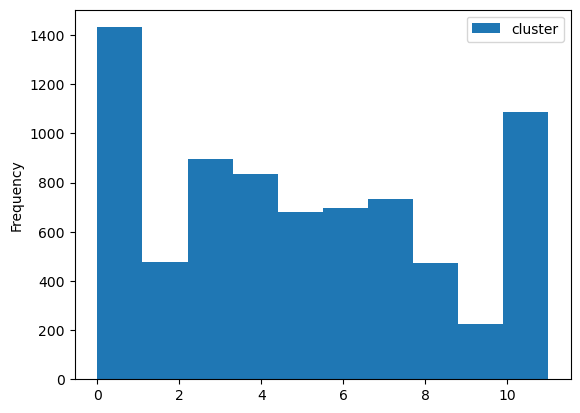

In [121]:
y_test.plot.hist()

Qualified Purchase distribution of y_train:
0    0.659852
1    0.340148
Name: purchase_qualified, dtype: float64

Qualified Purchase distribution of y_test:
0    0.65201
1    0.34799
Name: purchase_qualified, dtype: float64

Logistic Regression Model Coefficients in descending order:
reward: 0.20
OfrTyp_discount: 0.08
duration: 0.02
email: 0.02
web: 0.00
OfrTyp_informational: -0.01
social: -0.02
OfrTyp_bogo: -0.06
mobile: -0.07
difficulty: -0.16

Accuracy of Logistic Regression Model on test dataset: 0.6520095503382412


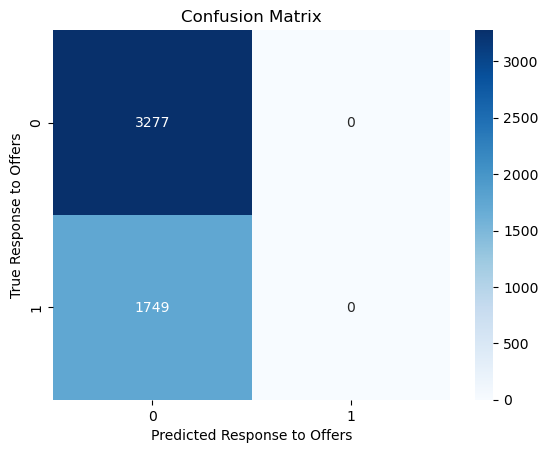

In [122]:
# KEEP since predicting every record y_test as 1:
# Q3: build a model that predicts whether or not someone will respond to an offer.
# Working version1
# split data into training and test sets
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    combineddf3cluster[[
        'reward', 'difficulty', 'duration', 'social', 'mobile', 'email', 'web',
        'OfrTyp_bogo', 'OfrTyp_discount', 'OfrTyp_informational'
    ]],
    combineddf3cluster['purchase_qualified'],
    test_size=0.2,
    random_state=42)

# Print the class distribution of y_train and y_test
print("Qualified Purchase distribution of y_train:")
print(y_train.value_counts(normalize=True))
print("\nQualified Purchase distribution of y_test:")
print(y_test.value_counts(normalize=True))

# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Fit a logistic regression model
clf = LogisticRegression(random_state=42)
clf.fit(X_train, y_train)

# Print the coefficients of the logistic regression model
clf_coefficents = clf.coef_[0]
# create a list of tuples containing coefficients and feature names
coef_tuples = list(
    zip(clf_coefficents, [
        'reward', 'difficulty', 'duration', 'social', 'mobile', 'email', 'web',
        'OfrTyp_bogo', 'OfrTyp_discount', 'OfrTyp_informational'
    ]))

# sort the list in descending order of coefficients
coef_tuples.sort(reverse=True)

# print coefficients and feature names in the sorted order
print("\nLogistic Regression Model Coefficients in descending order:")
for coef, feature in coef_tuples:
    print(f"{feature}: {coef:.2f}")

# Predict on X_test set on the Logistic Regression Model
y_pred = clf.predict(X_test)

# evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
print("\nAccuracy of Logistic Regression Model on test dataset:", accuracy)

# compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# plot confusion matrix
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Response to Offers")
plt.ylabel("True Response to Offers")
plt.show()

KEEP The coefficients for the features used are positive, indicating that they have a positive effect on the likelihood of a customer making a purchase on given offer. Specifically:
# below needs revisited
- email - has the highest value indicating that customers are more likely to make a purchase when an offer is emailed.
- mobile - has the second highest value indicating that customers are more likely to make a purchase when an offer is sent on mobile device (as a text message, assuming).
- duration - has the third highest value indicating that customers are more likely to make a purchase based on the duration associated with an offer.
- OfrTyp_informational and web - are almost tied for customer response to information offers and offers on the web channel.
- Difficulty: A higher value for the difficulty of an offer corresponds to a higher coefficient, indicating that customers are more likely to make a purchase when the difficulty of an offer is higher.
- reward, social, OfrTyp_discount: are almost tied for customer response to reward offers, offers on the scoial media and discount type offer. All indicating that customers are more likely to make a purchase when the these feature values are higher.
- BOGO Offers: A positive coefficient for the BOGO offer type indicates that customers are more likely to make a purchase when the offer type is BOGO. Interestingly BOGO Offers have least coeffiecient value indicating customers do not prefer buying two of same drinks or articles!

## KEEP Q: Use above Logistics Regression model to create a target customer list for a new offer:

Let's create customer dataset by cartesian product between existing profile dataset with a new offer in "portfolio new" dataset so all customers will have that offer assigned. Then we will use this dataset to predict probability of purchase by each customer. Chosing customers with "purchase probability" > .5 will select those customers. This threadhold can be tweak to limit the number of customers in the target list.

In [123]:
# KEEP # Let's create offer template using an existing offer
portfoliodf_NEW = portfoliodf_clean.head(1).copy()

# Change few offer parameters
portfoliodf_NEW = portfoliodf_NEW.assign(id="New Spring 2023 Discount Offer",
                                         reward=5,
                                         duration=2,
                                         difficulty=15,
                                         OfrTyp_informational=0,
                                         OfrTyp_discount=1,
                                         OfrTyp_bogo=0,
                                         social=0)
print("Sample New Offer:\n", portfoliodf_NEW)

# Create customer data by cartesian product between existing profile data above portfoliodf_NEW
customer_data = pd.merge(portfoliodf_NEW.assign(key=1),
                         profileDF_clean.assign(key=1),
                         on='key',
                         how='outer')

# drop the key column, rename id_y
customer_data = customer_data.drop(columns=['key']).rename(columns={
    "id_x": "id",
    "id_y": "offer_id"
})

info_on_df(customer_data)

Sample New Offer:
    reward  difficulty  duration                              id  social  web  \
0       5          15         2  New Spring 2023 Discount Offer       0    0   

   mobile  email  OfrTyp_bogo  OfrTyp_discount  OfrTyp_informational  
0       1      1            0                1                     0  
------------------------------------
Shape of DataFrame: (17000, 65)
Columns of DataFrame: Index(['reward', 'difficulty', 'duration', 'id', 'social', 'web', 'mobile',
       'email', 'OfrTyp_bogo', 'OfrTyp_discount', 'OfrTyp_informational',
       'offer_id', 'income_0_20k', 'income_20_30k', 'income_30_40k',
       'income_40_50k', 'income_50_60k', 'income_60_70k', 'income_70_80k',
       'income_80_90k', 'income_90_100k', 'income_100_110k', 'income_110_120k',
       'income_120+', 'tenure_days_0_15', 'tenure_days_15_30',
       'tenure_days_30_45', 'tenure_days_45_60', 'tenure_days_60_75',
       'tenure_days_75_90', 'tenure_days_90_105', 'tenure_days_105_120',
       

In [124]:
# KEEP Use above to predict whether someone will respond to an offer, we can use it to create a target
# customer list by predicting the likelihood of response for each customer in new dataset we
# created above. This code can be used for new customer list.

# preprocess customer_data which contains new offer assigned to each customer
X = scaler.transform(customer_data[[
    'reward', 'difficulty', 'duration', 'social', 'mobile', 'email', 'web',
    'OfrTyp_bogo', 'OfrTyp_discount', 'OfrTyp_informational'
]])

# predict likelihood of response for each customer to the new offer
y_pred = clf.predict_proba(X)[:, 1]

# add predicted response probabilities to customer data
customer_data["response_probability"] = np.round(y_pred, 2)

# let's see how does the response_probability look
print("New Offer Response Probability:\n",
      customer_data["response_probability"].describe())

# filter for high-potential customers, this threshold can be tweaked
target_customers = customer_data[customer_data["response_probability"] > 0.5]
info_on_df(target_customers)

# export target customer list to CSV
target_customers.to_csv("target_customers.csv", index=False)

New Offer Response Probability:
 count    1.700000e+04
mean     3.400000e-01
std      8.127072e-14
min      3.400000e-01
25%      3.400000e-01
50%      3.400000e-01
75%      3.400000e-01
max      3.400000e-01
Name: response_probability, dtype: float64
------------------------------------
Shape of DataFrame: (0, 66)
Columns of DataFrame: Index(['reward', 'difficulty', 'duration', 'id', 'social', 'web', 'mobile',
       'email', 'OfrTyp_bogo', 'OfrTyp_discount', 'OfrTyp_informational',
       'offer_id', 'income_0_20k', 'income_20_30k', 'income_30_40k',
       'income_40_50k', 'income_50_60k', 'income_60_70k', 'income_70_80k',
       'income_80_90k', 'income_90_100k', 'income_100_110k', 'income_110_120k',
       'income_120+', 'tenure_days_0_15', 'tenure_days_15_30',
       'tenure_days_30_45', 'tenure_days_45_60', 'tenure_days_60_75',
       'tenure_days_75_90', 'tenure_days_90_105', 'tenure_days_105_120',
       'tenure_days_120_135', 'tenure_days_135_150', 'tenure_days_150_165',
     

<AxesSubplot: ylabel='Frequency'>

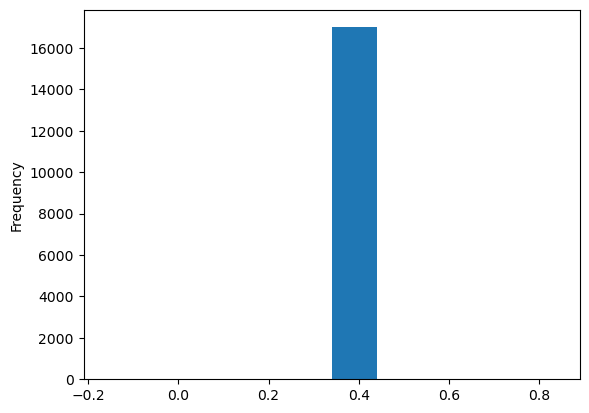

In [125]:
customer_data["response_probability"].plot.hist(bins=10)

# 5. Evaluation
Which model best meets the business objectives?¶
The LassoCV model explains the 95% of the variance for 60 variables predicting the price. Lasso regression is helpful in getting rid of variables when there are too many of them, in our case we had 350+.

## 6. Deployment 
#### How do stakeholders access the results?

# ===================================
Model that predicts how much someone will spend based on demographics and offer type.